https://github.com/minaxixi/Kaggle-M5-Forecasting-Accuracy/blob/master/model_recursive.ipynb

This code is inspired by minaxixi code for Kaggle M5 competition, it uses LighGBM, gradient boosting regressor and recursive multistep forecasting

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Function to reduce memory usage of the dataset

In [57]:

def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df



**Putting dataset of 5min for 1 year, which is imported from github depository**

In [58]:
data = pd.read_excel('https://github.com/cruveilc/Occupancy-Forecasting/blob/main/output.xlsx?raw=true',
sheet_name=0,
header=0,
index_col=[0],
keep_default_na=True
).pipe(reduce_mem_usage, verbose=True)

#data = data[data.index.dayofweek < 5]
#data = data.between_time('06:00','23:00')

Mem. usage decreased to  3.24 Mb (48.4% reduction)


In [59]:
data.head()

Toffice_reference  humidity  ...     door     label
time                                              ...                   
2015-01-06 15:00:00          19.450001      42.0  ...  1.00000  1.128000
2015-01-06 15:05:00          19.450001      42.0  ...  1.00000  0.622000
2015-01-06 15:10:00          19.450001      42.0  ...  1.00000  0.634000
2015-01-06 15:15:00          19.450001      42.0  ...  0.39944  0.285733
2015-01-06 15:20:00          19.450001      42.0  ...  0.00000  0.094000

[5 rows x 7 columns]

In [60]:
data.tail()

Toffice_reference  humidity  ...  door  label
time                                              ...             
2015-12-30 00:05:00              18.35      33.0  ...   0.0   0.01
2015-12-30 00:10:00              18.35      33.0  ...   0.0   0.01
2015-12-30 00:15:00              18.35      33.0  ...   0.0   0.01
2015-12-30 00:20:00              18.35      33.0  ...   0.0   0.01
2015-12-30 00:25:00              18.35      33.0  ...   0.0   0.01

[5 rows x 7 columns]

In [61]:
data.describe()

Toffice_reference       humidity  ...           door          label
count      102930.000000  102930.000000  ...  102930.000000  102930.000000
mean           23.035162      36.421188  ...       0.115509       0.538199
std             3.671053       7.905647  ...       0.313160       0.838787
min            14.120000      20.000000  ...       0.000000      -0.813333
25%            19.920000      31.000000  ...       0.000000       0.000000
50%            22.471015      37.000000  ...       0.000000       0.045015
75%            25.879999      42.000000  ...       0.000000       0.961390
max            33.410000     127.500000  ...       1.000000       5.000000

[8 rows x 7 columns]

**Importing the calendar and creating a calendar dataframe**

In [62]:
!pip install icalendar

In [63]:
from icalendar import Calendar, Event
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import datetime

In order to use the calendar you need to import it and place it in content folder, or just change the file location as you wish.

The main idea behind the calendar is to read it using the Icalendar library, and to extract all the information regarding the name of the event, and the starting and ending date. For some dates and one hour eventthere are multiple events, which I simply decided to keep the first appearing event (improvements could have been made by implementing a second column called "parallel event".
Then the calendar dataframe must be suited to the dataframe. Since most events appear at sharp hours, and that the dataset is ssampled each 5min all the events are reported in the dataset event. 

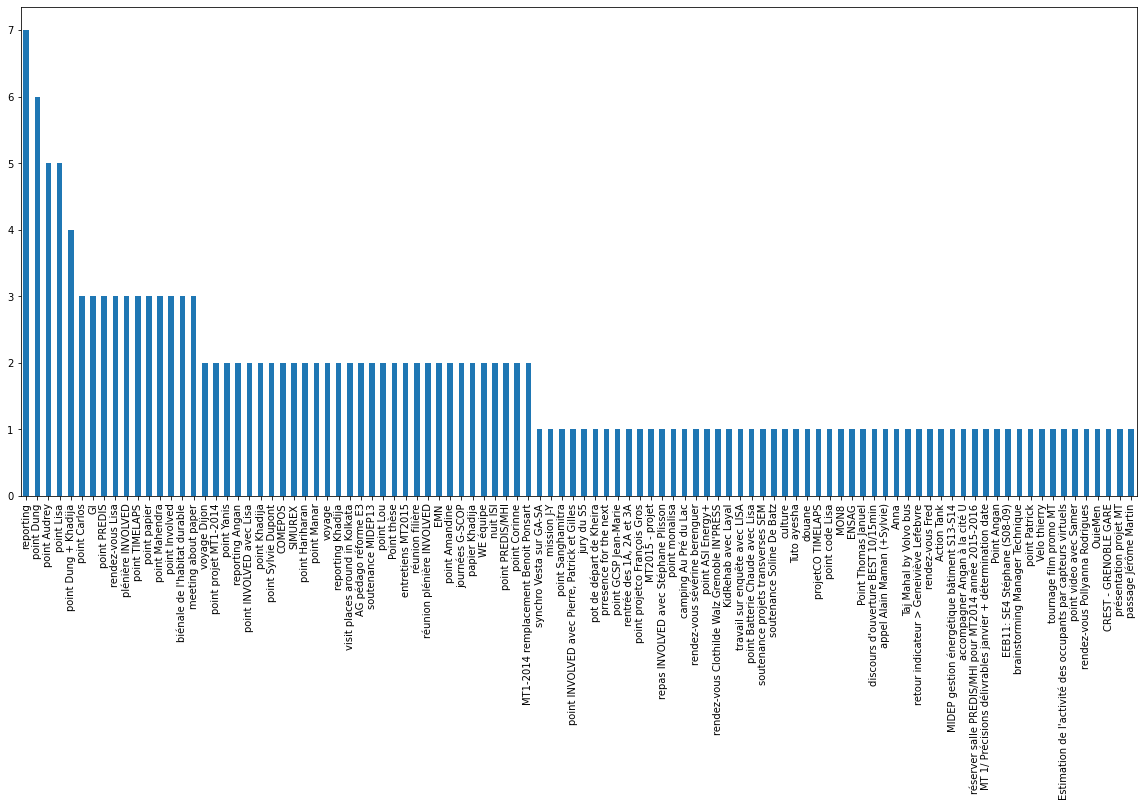

                                         evenement  ... label
debut                                               ...      
2015-01-05 09:15:00                          POO13  ...     1
2015-01-05 15:00:00        point Murielle sur DPEA  ...     2
2015-01-06 13:00:00                réunion mission  ...     1
2015-01-07 07:30:00              Rdv projet Ayesha  ...     1
2015-01-07 08:30:00  appeler amandine pour facture  ...     1

[5 rows x 4 columns]
Empty DataFrame
Columns: [evenement, debut, fin, label]
Index: []
fin test


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

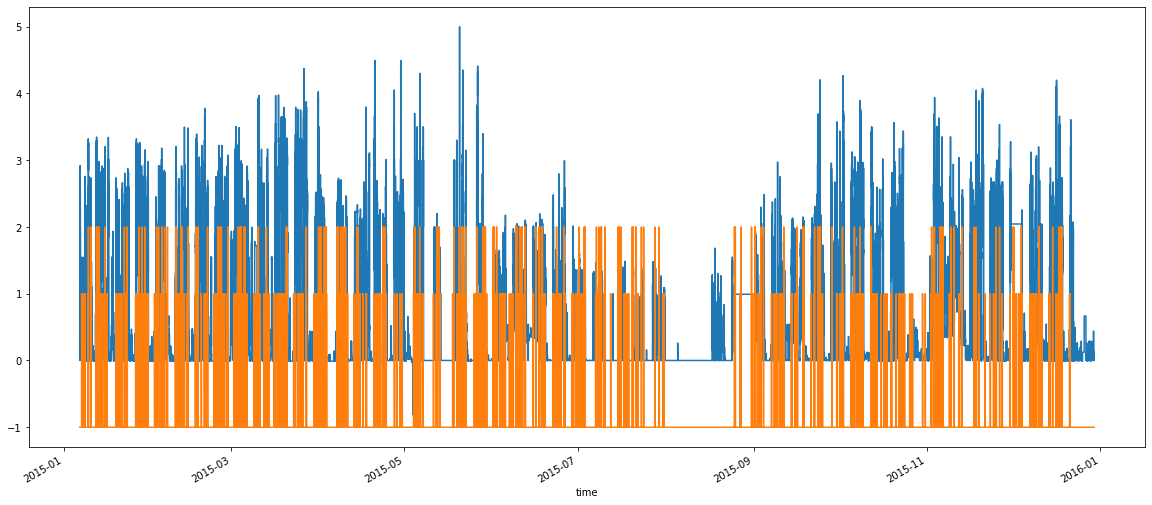

In [64]:
evenement = []
debut = []
fin =[]


g = open('/content/stephane_stephane.ploix@gmail.com.ics','rb')
gcal = Calendar.from_ical(g.read().decode())
for component in gcal.walk():
    if component.name == "VEVENT":

        evenement.append(str((component.get('summary'))))
        if len(str(component.get('dtstart').dt)) >12:
            debut.append(datetime.strptime(str(component.get('dtstart').dt)[:-6],'%Y-%m-%d %H:%M:%S'))
        else:
            debut.append(datetime.strptime(str(component.get('dtstart').dt), '%Y-%m-%d'))
        if component.get('dtend') is not None:
            fin.append(component.get('dtend').dt)
        else:
            fin.append("Nan")

g.close()

calendrier = pd.DataFrame({'evenement': evenement,'debut':debut,'fin':fin})
calendrier['debut'] =pd.to_datetime(calendrier.debut)
calendrier.sort_values(['debut'], inplace=True)
calendrier = calendrier.set_index(calendrier['debut'])
calendrier = calendrier['2015-01-04':'2015-12-31']


plt.figure(figsize=(20,9))
calendrier.evenement.value_counts()[0:100].plot.bar()
plt.show()

label = []
for k in calendrier.index:
    if "point" in calendrier['evenement'].loc[str(k)]:
        label.append(2)
    else:
        label.append(1)

calendrier['label']=label
print(calendrier.head())



cal = []
nom = []
for k in data['label']:
    cal.append(-1)
    nom.append("None")

data['calendrier'] = cal
data['nom']=nom

calendrier.drop_duplicates(subset ="debut",
                     keep = False, inplace = True)
print(calendrier[calendrier.index.duplicated()])
print("fin test")

for k in calendrier.index:
    if k in data.index:
        data['calendrier'].loc[str(k)] = calendrier['label'].loc[str(k)]
        data['nom'].loc[str(k)] = calendrier['evenement'].loc[str(k)]

plt.figure(figsize=(20,9))
data['label'].plot()
data['calendrier'].plot()
plt.show()

As we can see most of the events coincide with occupancy in the office, and a strong occupancy often matches with he "point" event.

In [65]:
data[500:800]


Toffice_reference  humidity  ...  calendrier   nom
time                                              ...                  
2015-01-08 08:40:00          19.450001      42.0  ...          -1  None
2015-01-08 08:45:00          19.450001      42.0  ...          -1  None
2015-01-08 08:50:00          19.450001      42.0  ...          -1  None
2015-01-08 08:55:00          19.450001      42.0  ...          -1  None
2015-01-08 09:00:00          19.450001      42.0  ...          -1  None
...                                ...       ...  ...         ...   ...
2015-01-09 09:15:00          19.450001      42.0  ...          -1  None
2015-01-09 09:20:00          19.450001      42.0  ...          -1  None
2015-01-09 09:25:00          19.450001      42.0  ...          -1  None
2015-01-09 09:30:00          19.450001      42.0  ...          -1  None
2015-01-09 09:35:00          19.450001      42.0  ...          -1  None

[300 rows x 9 columns]

In [66]:
calendrier

evenement  ... label
debut                                                                   ...      
2015-01-05 09:15:00                                              POO13  ...     1
2015-01-05 15:00:00                            point Murielle sur DPEA  ...     2
2015-01-06 13:00:00                                    réunion mission  ...     1
2015-01-07 07:30:00                                  Rdv projet Ayesha  ...     1
2015-01-07 08:30:00                      appeler amandine pour facture  ...     1
...                                                                ...  ...   ...
2015-12-18 10:00:00                                       point Ayesha  ...     2
2015-12-18 13:00:00             point Maxime Derrien et Nicolas Munsch  ...     2
2015-12-18 14:30:00  rendez-vous Christophe Bravard, Corinne et Hai...  ...     1
2015-12-21 08:00:00                         Départ étranger thèse Lisa  ...     1
2015-12-21 13:00:00                                        Tuto ayesha  ...     1

[596 rows x 4 columns]

**Data analysis**

Let's explore the data and check its time series properties. Since the pattern is mostly repeating each week we can plot the rolling mean over a week, a day and 10 days to have a general impression on trend

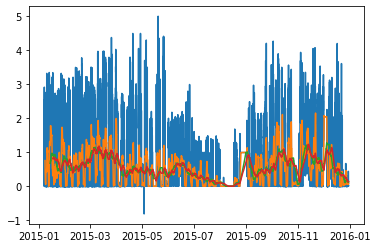

In [67]:
plt.plot(data.index, data['label'])
plt.plot(data.index, data['label'].rolling(24*12).mean(), label='1-day rolling mean')
plt.plot(data.index, data['label'].rolling(7*24*12).mean(), label='1-day rolling mean')
plt.plot(data.index, data['label'].rolling(10*24*12).mean(), label='1-day rolling mean')

We can observe that there is no particular trend but that the rollin mean over a week is almost linear on some timedate segments.

Now we decompose the data into trend, seasonal and residual. There is an important week seasonality and still a lot of noise which will make it difficult to have accurate forecasting results.

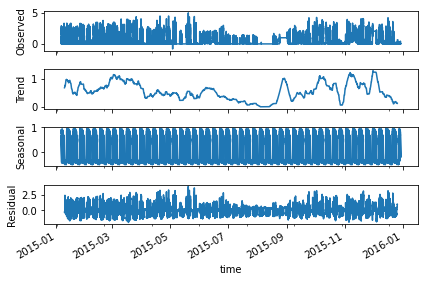

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

days_per_week = 7*24*12

time_series = data["label"]
sj_sc = seasonal_decompose(time_series,freq = days_per_week)
sj_sc.plot()

plt.show()

An important test regarding timeseries is the stationarity or not of the data. 

In [69]:


from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window =24*12*7 ,cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='{} Day Rolling Mean'.format(window))
    std = plt.plot(rolstd, color='black', label = '{} Day Rolling Std'.format(window))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)



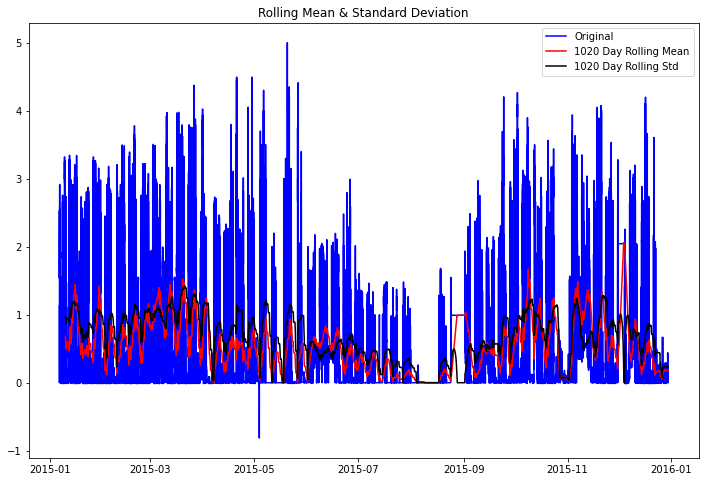

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                    -24.308637
p-value                             0.000000
#Lags Used                         15.000000
Number of Observations Used    102914.000000
Critical Value (1%)                -3.430414
Critical Value (5%)                -2.861568
Critical Value (10%)               -2.566785
dtype: float64


In [70]:
test_stationarity(time_series, 7*24*12, 0.05)

The p-value is really small confirming that we have a stationary time series. This confirm our intent to test also the ARIMA model.

In order to improve the accuracy of the model we give as an input feature the data characteristics since the model doesn't explicitly use the date.

In [71]:
data.insert(0,'hour',data.index.hour)
data.insert(0,'dayofweek',data.index.dayofweek)
data.insert(0,'dayofmonth',data.index.day)
data.insert(0,'year',data.index.year)


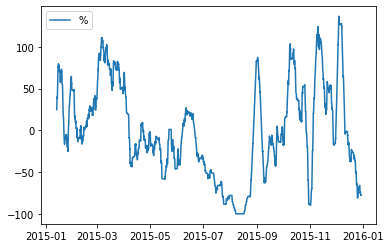

In [72]:
plt.plot(data.index, (data['label'].rolling(7*24*12).mean() / data['label'].rolling(5*17*12).mean().mean() - 1)*100)
plt.legend('% change to the mean')
plt.show()

**Feature engineering to create inputs based on statistics**

In this part we are going to implement more sophisticated feature engineering. In stead of directly giving a sequence of the past data as it was done for the different neural networks we going to give statistical features that we observed above such as the rolling mean, the standard deviation or the maximum over a certain amount of time.

We try to give information about the last day, the last week, the last month and the last 2 months . A lot if different combinations were tried since we are doing a feature importance study later. We saw for NN models the calendar feature was not giving any improvement in the model, here we tried to also give statistical characteristics as input.

In [73]:
def create_features(df):
    '''
    create features using rolling and lag
    '''
    
    # these are hard-coded for final submission
    # groupby_cols, target_cols, agg_functions, rolling_windows, lags
    agg_list = [
        [['time'], 'label', 'mean', [12*24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50,100,150], [1,2,3,4,5,10,15,20,25,7*12*17,14*12*17]],
        [['time'], 'label', 'mean', [7*12*24], [7*12*24, 365*12*24]],
        [['time'], 'label', 'mean', [7*12*24, 14*12*24, 30*12*24, 60*12*24, 180], [28]],
        [['time'], 'label', 'std',  [7*12*24, 14*12*24, 30*12*24, 60*12*24], [28*12*17]],
        [['time'], 'label', 'max', [365*12*24], [1*12*24]],
        [['time'], 'label', 'mean', [7*12*24], [1*12*24]],
        [['time'], 'calendrier', 'mean', [12*24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50], [1,2,3,4,5,10,15,20,25,7*12*17,14*12*17]],
        
    ]
    
    for i, item in enumerate(agg_list):
        print(i)
        
        # unpack the parameters
        groupby_cols, target_col, agg_function, rolling_windows, lags = item
        groupby_col_str = "_".join(groupby_cols)
        
        for lag in lags:
            for rolling_window in rolling_windows:
                col_name = agg_function+'_'+target_col+'_per_'+groupby_col_str+'_r'+str(rolling_window)+'_lag_'+str(lag)
                #df[col_name] = df[target_col].apply(lambda x: x.rolling(window=rolling_window).agg(agg_function).shift(lag))
                df[col_name] = df[target_col].rolling(rolling_window).agg(agg_function).shift(lag)
    ## price related features
    #df['sell_price_norm'] = df['sell_price'] / df['max_sell_price_per_store_id_item_id_r365_lag_1']
    #df['sell_price_momentum'] = df['sell_price'] / df['mean_sell_price_per_store_id_item_id_r7_lag_1']

    return df

**Function to create the future data input**

Here we are creating a sequence of the calendar for the timesteps we are trying to forecast. Since the model took some time we did not perform a sensitivity analysis, probably we could have got better results if using 1 day instead of using 2 days as seen in the other models. 

In [74]:
def calendar_feature(df):
  k = range(1,12*24*2)
  agg_list = [
        [['time'], 'calendrier',k,

    ]]
    
  for i, item in enumerate(agg_list):
        print(i)
        
        # unpack the parameters
        groupby_cols, target_col, lags = item
        groupby_col_str = "_".join(groupby_cols)
        
        for lag in lags:
                col_name = '_'+target_col+'_per_'+groupby_col_str+'_r''-_lag_'+str(lag)
                #df[col_name] = df[target_col].apply(lambda x: x.rolling(window=rolling_window).agg(agg_function).shift(lag))
                df[col_name] = df[target_col].shift(-lag)
    ## price related features
    #df['sell_price_norm'] = df['sell_price'] / df['max_sell_price_per_store_id_item_id_r365_lag_1']
    #df['sell_price_momentum'] = df['sell_price'] / df['mean_sell_price_per_store_id_item_id_r7_lag_1']

  return df

Since this input did not improved the accuracy we didn't use it in the final model.

Here we create the dataset with past data input features:

In [75]:
data2 = create_features(data)
#data2 = calendar_feature(data2)
#un hashtag if you want to test the calendar

0
1
2
3
4
5
6


In [76]:
data2[1000:5000].tail()

year  ...  mean_calendrier_per_time_r50_lag_2856
time                       ...                                       
2015-01-23 23:15:00  2015  ...                                   -1.0
2015-01-23 23:20:00  2015  ...                                   -1.0
2015-01-23 23:25:00  2015  ...                                   -1.0
2015-01-23 23:30:00  2015  ...                                   -1.0
2015-01-23 23:35:00  2015  ...                                   -1.0

[5 rows x 422 columns]

It results into a lot of columns in the dataframe, to improve the speed of our next algorithm lines we are reducing the memory

In [77]:
data3 = reduce_mem_usage(data2, verbose=True)

Mem. usage decreased to 170.21 Mb (49.1% reduction)


We are reducing the time to access the dataset by saving it as pickle.

In [78]:
data3.to_pickle("/content.pkl")

In [116]:
sales_by_date = pd.read_pickle("/content.pkl")

In [117]:
sales_by_date['label']=sales_by_date['label'].clip(lower=0)

In [118]:
sales_by_date

year  ...  mean_calendrier_per_time_r50_lag_2856
time                       ...                                       
2015-01-06 15:00:00  2015  ...                                    NaN
2015-01-06 15:05:00  2015  ...                                    NaN
2015-01-06 15:10:00  2015  ...                                    NaN
2015-01-06 15:15:00  2015  ...                                    NaN
2015-01-06 15:20:00  2015  ...                                    NaN
...                   ...  ...                                    ...
2015-12-30 00:05:00  2015  ...                                   -1.0
2015-12-30 00:10:00  2015  ...                                   -1.0
2015-12-30 00:15:00  2015  ...                                   -1.0
2015-12-30 00:20:00  2015  ...                                   -1.0
2015-12-30 00:25:00  2015  ...                                   -1.0

[102930 rows x 422 columns]

Let's chose the columns we want to predict and the ones we don't wish to use.

In [119]:

unused_cols = ['occupancy','Toffice_reference','humidity','detected_motions','office_CO2_concentratio','door','label','nom']

feature_cols = list(set(sales_by_date.columns) - set(unused_cols))

In [120]:
feature_cols

['mean_label_per_time_r15_lag_25',
 'mean_calendrier_per_time_r12_lag_2856',
 'mean_calendrier_per_time_r7_lag_5',
 'mean_calendrier_per_time_r288_lag_20',
 'mean_label_per_time_r5_lag_25',
 'mean_label_per_time_r10_lag_4',
 'mean_label_per_time_r2_lag_3',
 'mean_label_per_time_r4_lag_20',
 'mean_calendrier_per_time_r13_lag_20',
 'mean_label_per_time_r100_lag_20',
 'mean_label_per_time_r11_lag_3',
 'mean_label_per_time_r15_lag_2856',
 'mean_calendrier_per_time_r15_lag_1428',
 'mean_calendrier_per_time_r7_lag_1428',
 'mean_label_per_time_r50_lag_1428',
 'std_label_per_time_r8640_lag_5712',
 'mean_label_per_time_r1_lag_1',
 'mean_label_per_time_r1_lag_3',
 'mean_calendrier_per_time_r11_lag_4',
 'mean_label_per_time_r288_lag_1',
 'mean_calendrier_per_time_r1_lag_15',
 'mean_calendrier_per_time_r288_lag_1',
 'mean_label_per_time_r15_lag_20',
 'mean_label_per_time_r13_lag_1',
 'mean_calendrier_per_time_r288_lag_15',
 'mean_label_per_time_r4_lag_4',
 'hour',
 'mean_calendrier_per_time_r3_lag

In [121]:
label_col = ['label']

**Hyperparameter tuning**

In order to train and test our model we are using a bit more than 75% for training.

In [85]:

X_train = sales_by_date[feature_cols][0 : 80000]
y_train = sales_by_date[label_col][0:80000]

X_test = sales_by_date[feature_cols][80000:]
y_test = sales_by_date[label_col][80000:]

In [86]:
X_test

mean_label_per_time_r15_lag_25  ...  mean_calendrier_per_time_r4_lag_2856
time                                                 ...                                      
2015-10-11 10:40:00                        0.108560  ...                                  -1.0
2015-10-11 10:45:00                        0.109893  ...                                  -1.0
2015-10-11 10:50:00                        0.109893  ...                                  -1.0
2015-10-11 10:55:00                        0.109893  ...                                  -1.0
2015-10-11 11:00:00                        0.109893  ...                                  -1.0
...                                             ...  ...                                   ...
2015-12-30 00:05:00                        0.009333  ...                                  -1.0
2015-12-30 00:10:00                        0.010000  ...                                  -1.0
2015-12-30 00:15:00                        0.010667  ...                                  -1.0
2015-12-30 00:20:00                        0.011333  ...                                  -1.0
2015-12-30 00:25:00                        0.012000  ...                                  -1.0

[22930 rows x 414 columns]

In [87]:
X_train.isna().sum()

mean_label_per_time_r15_lag_25             39
mean_calendrier_per_time_r12_lag_2856    2867
mean_calendrier_per_time_r7_lag_5          11
mean_calendrier_per_time_r288_lag_20      307
mean_label_per_time_r5_lag_25              29
                                         ... 
mean_label_per_time_r3_lag_10              12
mean_label_per_time_r50_lag_25             74
mean_calendrier_per_time_r288_lag_25      312
mean_label_per_time_r14_lag_25             38
mean_calendrier_per_time_r4_lag_2856     2859
Length: 414, dtype: int64

In [88]:
print("train", X_train.shape, y_train.shape)
print("test", X_test.shape, y_test.shape)

train (80000, 414) (80000, 1)
test (22930, 414) (22930, 1)


In [89]:
import gc
gc.collect()

32517

Now we are going to proceed to an hypertuning using 3 folds cross validation

It is important to note that the lightgbm can't make multioutput regression. That is why we are training the model to always forecast the one next step. In order to run correctly the prediction, we are using recursive prediction. That means that we are using a loop in which for the 24 hours we are going to update with the last predictions we made instead of giving the true value. This will be studier later on.

In [90]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

In [91]:
from sklearn.model_selection import TimeSeriesSplit

## define a 3-fold time-series split for cross validation

tscv = TimeSeriesSplit(n_splits=3)

In [92]:
## the parameter table for tuninig

param_dist = {
    'boosting_type': ['gbdt'],
    'objective': ['tweedie'],
    'tweedie_variance_power': [1.1],
    'n_estimators': [500],
    'metric': ['rmse'],
    'max_depth': [30, 50, 70],
    'num_leaves': [250, 500, 1000],
    'learning_rate': [0.03, 0.1],
    'feature_fraction': [0.5, 0.7],
    'bagging_fraction': [0.5, 0.7],
}

reg = lgb.LGBMRegressor()

In [93]:
## Set n_iter_search to be a higher value for actual hyperparameter tuning
## This is just to show the workflow

n_iter_search = 1

random_search = RandomizedSearchCV(
    reg,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)

Since we are studying a lot of features and making cross validation, this part takes about 20minutes to run.

In [94]:
%%time
## Train on the training portion of the CV
## Validated on the validation/test portion of the CV
## Early stopping using the test portion of the dataset

random_search.fit(
    X_train,
    y_train,
    eval_metric='rmse',
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=1,
)

[1]	training's rmse: 0.756293	valid_1's rmse: 0.817904
[2]	training's rmse: 0.692209	valid_1's rmse: 0.75178
[3]	training's rmse: 0.633218	valid_1's rmse: 0.690149
[4]	training's rmse: 0.578992	valid_1's rmse: 0.634988
[5]	training's rmse: 0.529616	valid_1's rmse: 0.585651
[6]	training's rmse: 0.484942	valid_1's rmse: 0.542967
[7]	training's rmse: 0.444622	valid_1's rmse: 0.50405
[8]	training's rmse: 0.40837	valid_1's rmse: 0.469653
[9]	training's rmse: 0.375808	valid_1's rmse: 0.440783
[10]	training's rmse: 0.346717	valid_1's rmse: 0.418921
[11]	training's rmse: 0.320417	valid_1's rmse: 0.397506
[12]	training's rmse: 0.296996	valid_1's rmse: 0.379067
[13]	training's rmse: 0.275962	valid_1's rmse: 0.362968
[14]	training's rmse: 0.257287	valid_1's rmse: 0.350115
[15]	training's rmse: 0.240789	valid_1's rmse: 0.339009
[16]	training's rmse: 0.226054	valid_1's rmse: 0.330014
[17]	training's rmse: 0.212971	valid_1's rmse: 0.322514
[18]	training's rmse: 0.201478	valid_1's rmse: 0.316424
[19]

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random...
                   param_distributions={'bagging_fraction': [0.5, 0.7],
                                        'boosting_type': ['gbdt'],
                                        'feature_fraction': [0.5, 

In [95]:
## take the best model from our randomized search

reg_model = random_search.best_estimator_

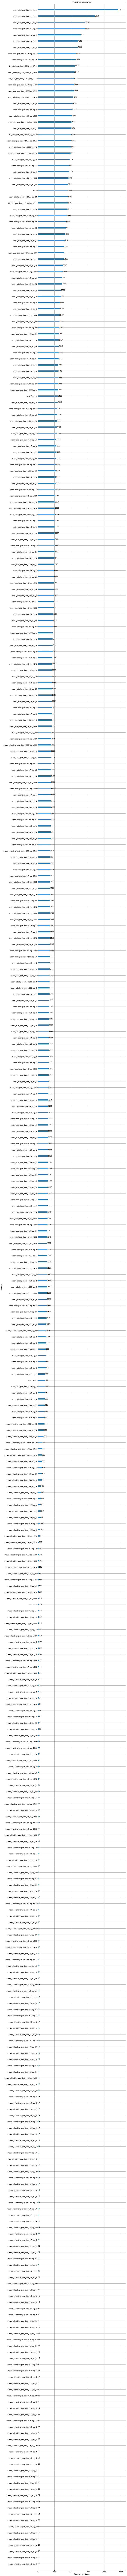

In [96]:
## examine the feature importane


lgb.plot_importance(reg_model, figsize=(10, 300))

**Prediction**

In [97]:
sales_by_date

year  ...  mean_calendrier_per_time_r50_lag_2856
time                       ...                                       
2015-01-06 15:00:00  2015  ...                                    NaN
2015-01-06 15:05:00  2015  ...                                    NaN
2015-01-06 15:10:00  2015  ...                                    NaN
2015-01-06 15:15:00  2015  ...                                    NaN
2015-01-06 15:20:00  2015  ...                                    NaN
...                   ...  ...                                    ...
2015-12-30 00:05:00  2015  ...                                   -1.0
2015-12-30 00:10:00  2015  ...                                   -1.0
2015-12-30 00:15:00  2015  ...                                   -1.0
2015-12-30 00:20:00  2015  ...                                   -1.0
2015-12-30 00:25:00  2015  ...                                   -1.0

[102930 rows x 422 columns]

As we told before in order to make a multistep prediction we need a function that updates the features with the past single output prediction that was made. 

In [ ]:
    agg_list = [
        [['time'], 'label', 'mean', [12*24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50,100,150], [1,2,3,4,5,10,15,20,25,7*12*17,14*12*17]],
        [['time'], 'label', 'mean', [7*12*24], [7*12*24, 365*12*24]],
        [['time'], 'label', 'mean', [7*12*24, 14*12*24, 30*12*24, 60*12*24, 180], [28]],
        [['time'], 'label', 'std',  [7*12*24, 14*12*24, 30*12*24, 60*12*24], [28*12*17]],
        [['time'], 'label', 'max', [365*12*24], [1*12*24]],
        [['time'], 'label', 'mean', [7*12*24], [1*12*24]],
        [['time'], 'calendrier', 'mean', [12*24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50], [1,2,3,4,5,10,15,20,25,7*12*17,14*12*17]],
        
    ]

In [204]:
def update_features_one_day(df, time):
    '''
    update lag/rolling features for 5 min only
    
    used for submission creation, when the predictions for 28 days are performed recursively
    '''
    
    from datetime import timedelta
    agg_list = [
        [['time'], 'label', 'mean', [12*24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,50,100,150], [1,2,3,4,5,10,15,20,25,7*12*17,14*12*17]],
 
 
    ]


    for i, item in enumerate(agg_list):
        print(i)
        # unpack the parameters
        groupby_cols, target_col, agg_function, rolling_windows, lags = item
        groupby_col_str = "_".join(groupby_cols)
        print(i+1)
        print(df.time)
        for lag in lags:
            print(i+2)
            for rolling_window in rolling_windows:
                print(i+3)
                col_name = agg_function+'_'+target_col+'_per_'+groupby_col_str+'_r'+str(rolling_window)+'_lag_'+str(lag)
                print(i+4)
                print(date-timedelta(hours=lag))
                print(df[(df.time <= date-timedelta(hours=lag))])
                df_window = df[(df.time <= date-timedelta(hours=lag)) & (df.time > date-timedelta(hours=lag+rolling_window))]
                print(df_window)
                print(i+5)
                df_window_grouped = df_window.agg({target_col : agg_function}).reindex(df.loc[df.time==time])
                print(i+6)
                print((df_window[target_col].values))
                df.loc[(df.time == time, col_name)] = df_window_grouped[target_col][0]


                #df[col_name] = df[target_col].rolling(rolling_window).agg(agg_function).shift(lag)
                
    #df.loc[df.date == date, 'sell_price_norm'] = df.loc[df.date == date, 'sell_price'] / df.loc[df.date == date, 'max_sell_price_per_store_id_item_id_r365_lag_1']
    #df.loc[df.date == date, 'sell_price_momentum'] = df.loc[df.date == date, 'sell_price'] / df.loc[df.date == date, 'mean_sell_price_per_store_id_item_id_r7_lag_1']
    
    return df

In [138]:
from datetime import timedelta

In [139]:
## perform recursive prediction

from datetime import datetime
from datetime import timedelta  

## create submission ID

# the magic scaling factor that applies on every score prediction
magic_factor = 1.0

# the threshold below which the prediction is set to zero
zero_threshold = 0.75

# start_date and the number of dates to be predicted
# this error analysis was performed when the validation set was not released. Please use 2016-04-24 to 2016-05-22 after the release


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


0.971227787916922
0.012541063
0.9922605584713409
0.01374398
0.9994954905955777
0.00011417342
1.0
0.0
0.9983574502607467
0.0018098928
0.993523060978236
0.008923267
0.9971979508700843
0.0038553711
0.9999834362453983
8.764792e-05
0.9982613641267345
0.0018895731
1.0
4.9826987e-05
1.0
0.0
0.8586432548120633
0.17313269
-0.07545111183588693
0.41325378
0.9395331083933357
0.052562844
0.93309512621464
0.029938582
0.7326591921740984
0.15530926
1.0
0.0
1.0
7.794673e-06
0.9390538575446588
0.047787894
0.7109216691044975
0.24615988


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.7113949546998093
0.13995278


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.932291335934038
0.106044665


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.7740578860419325
0.2676097


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.0
0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.0
7.4839227e-06


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.0
0.0020737024


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.0
4.9826987e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.0
2.7645965e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.0
2.2145328e-05


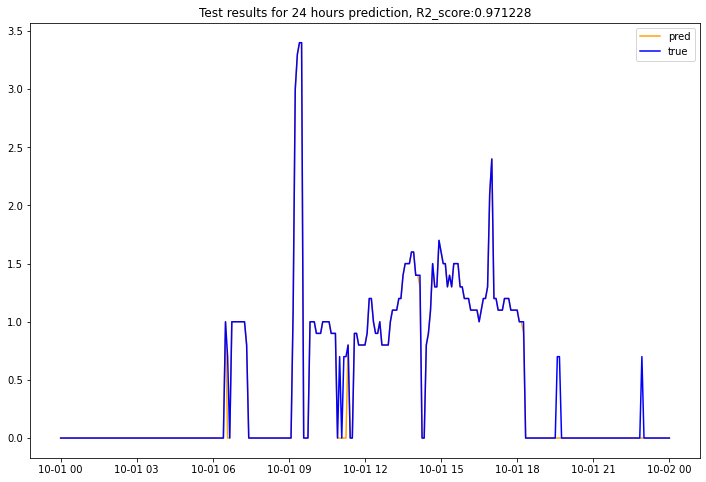

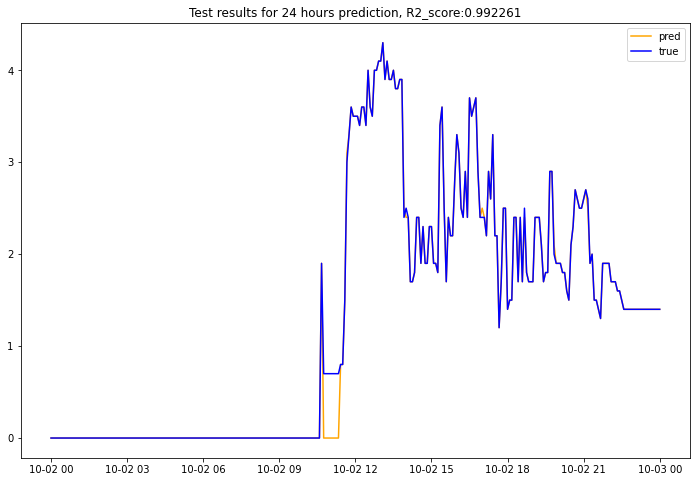

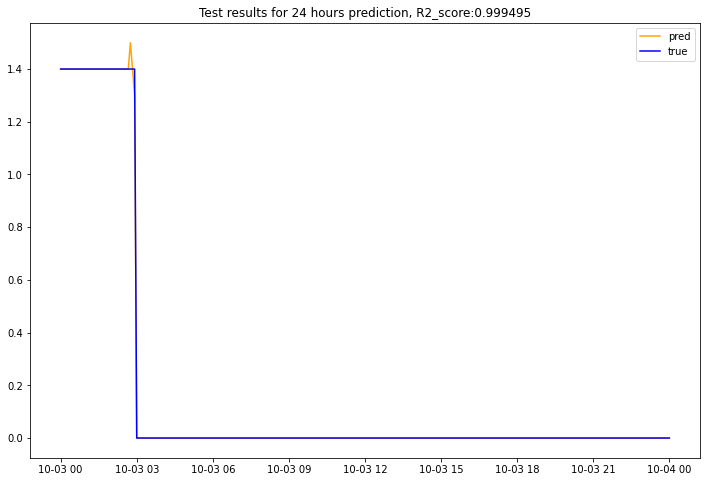

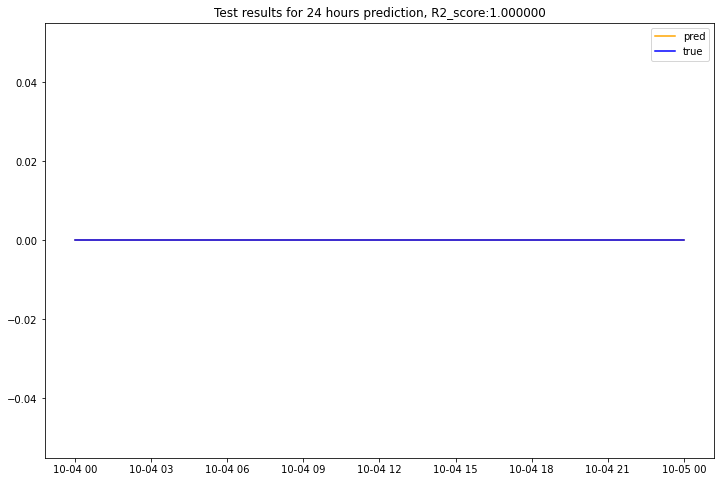

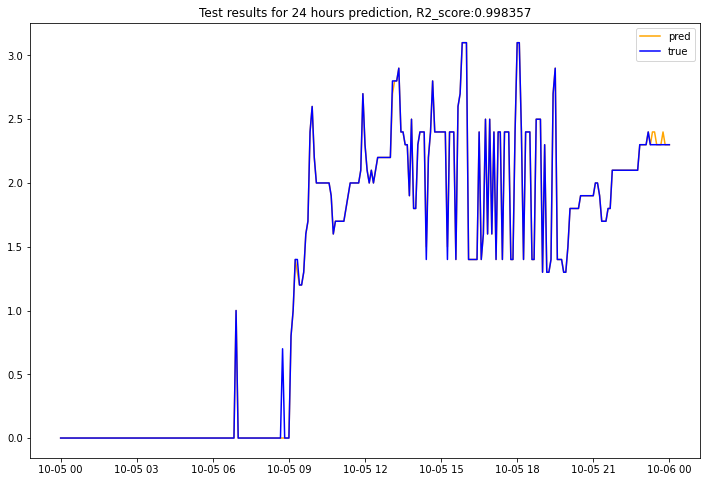

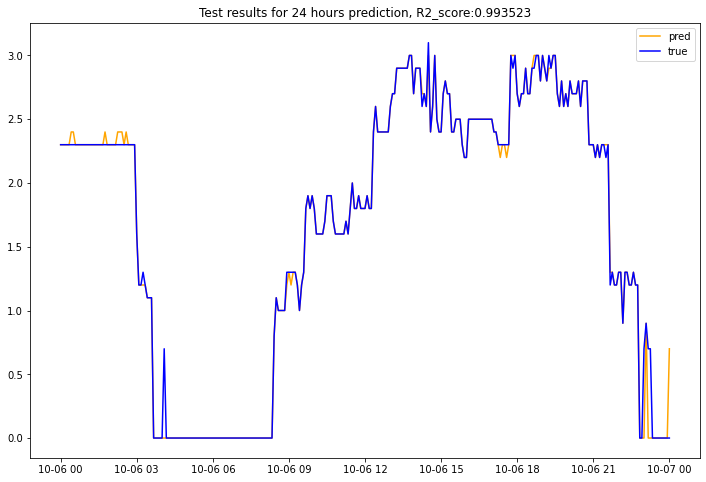

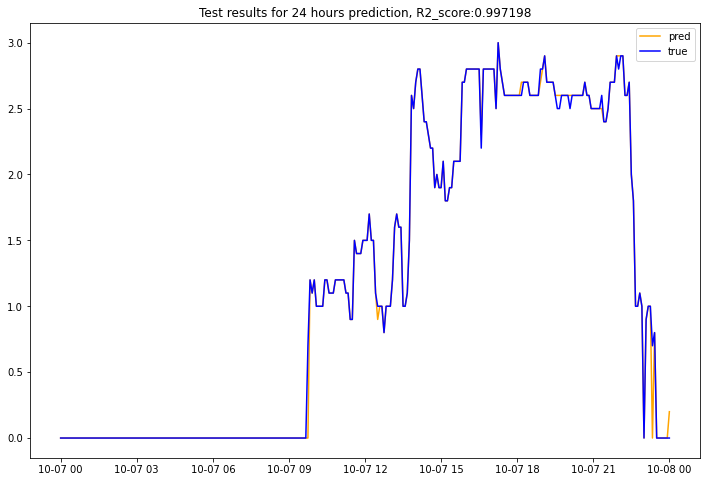

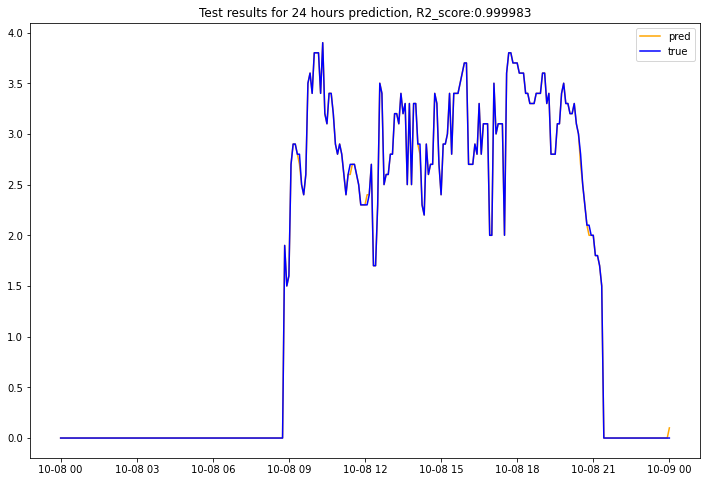

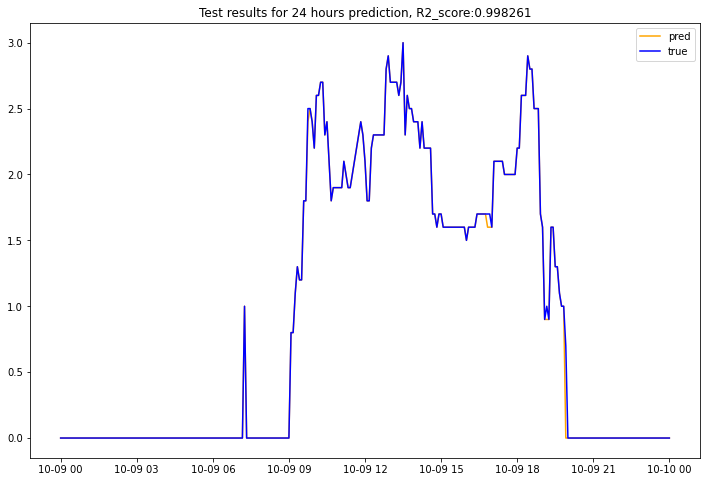

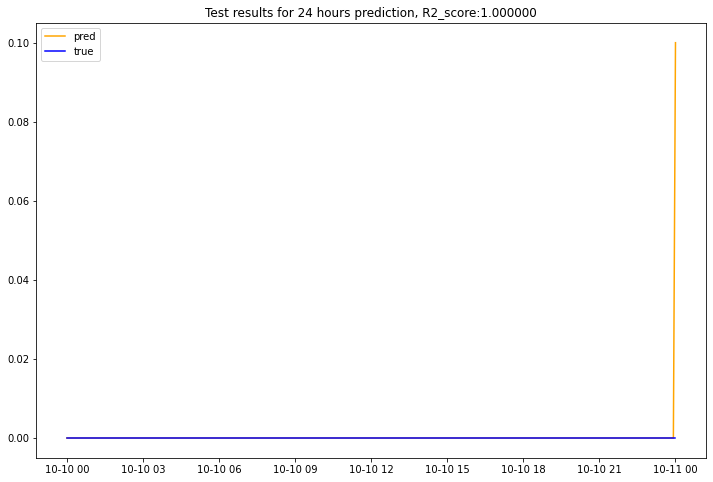

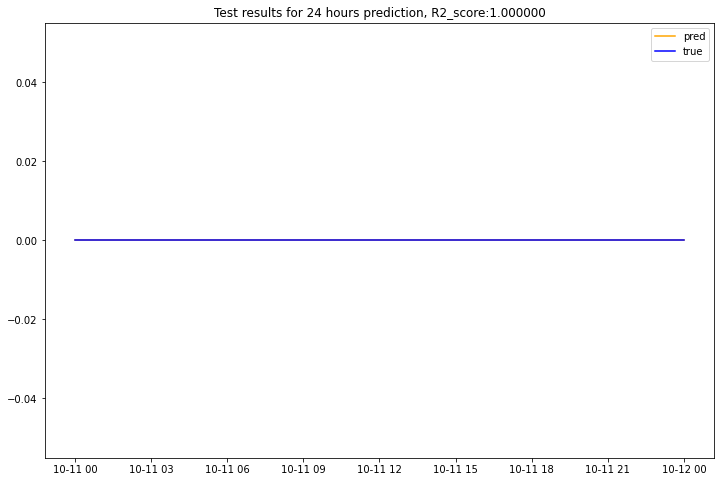

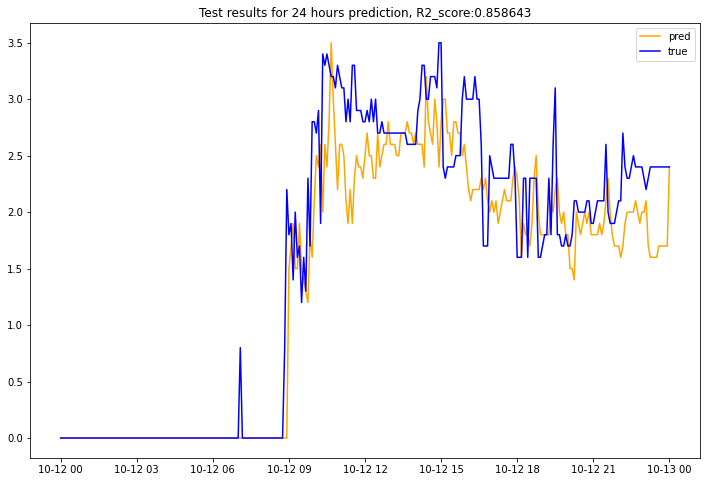

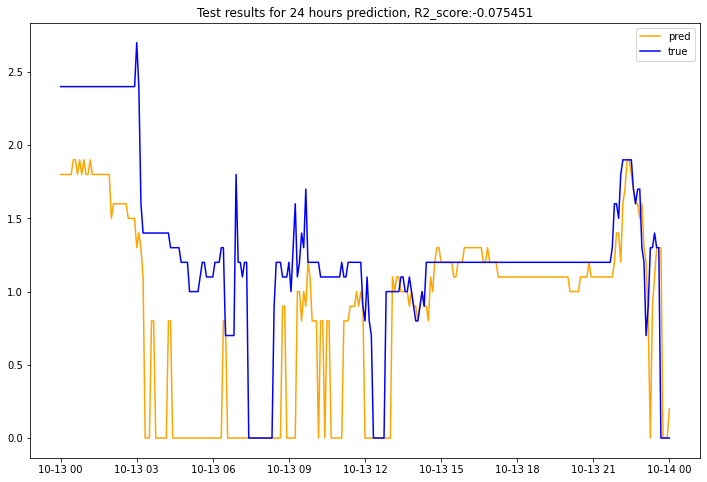

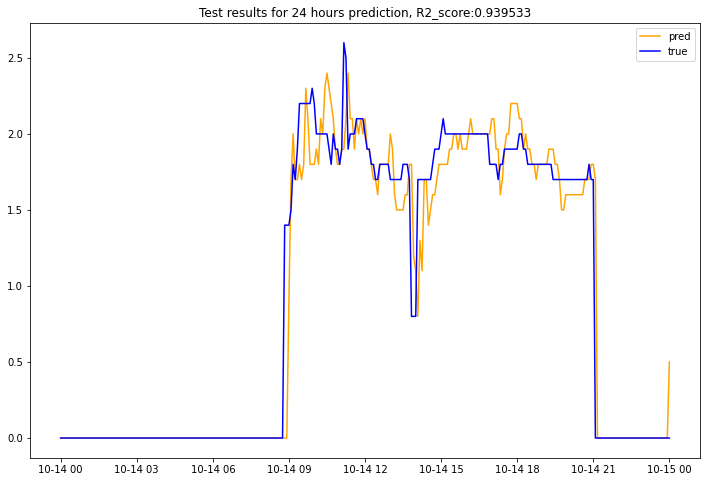

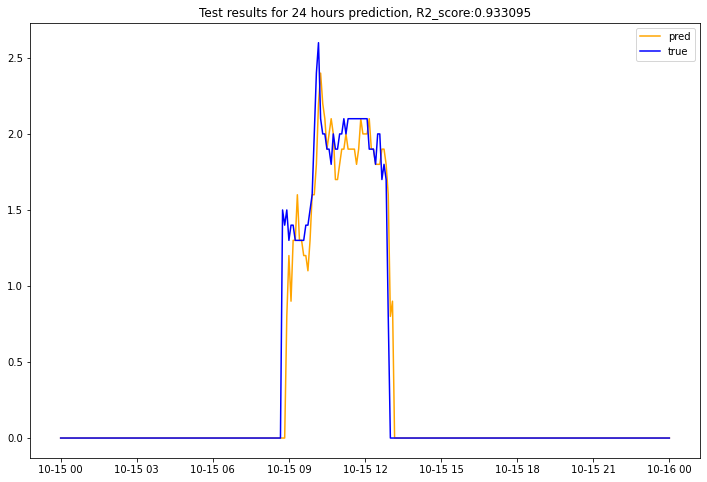

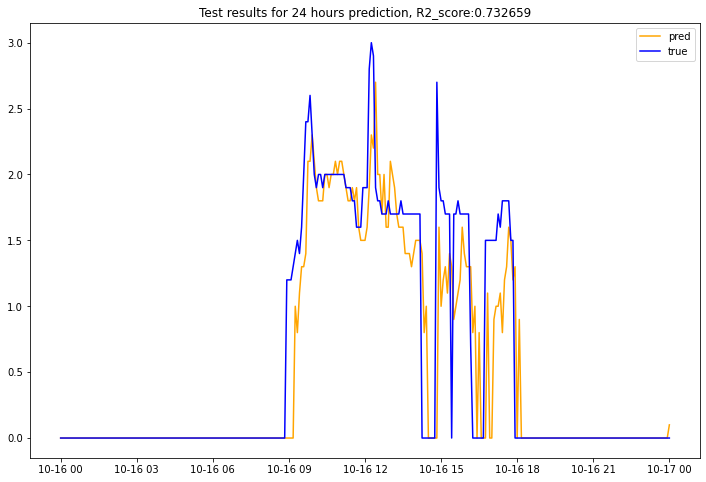

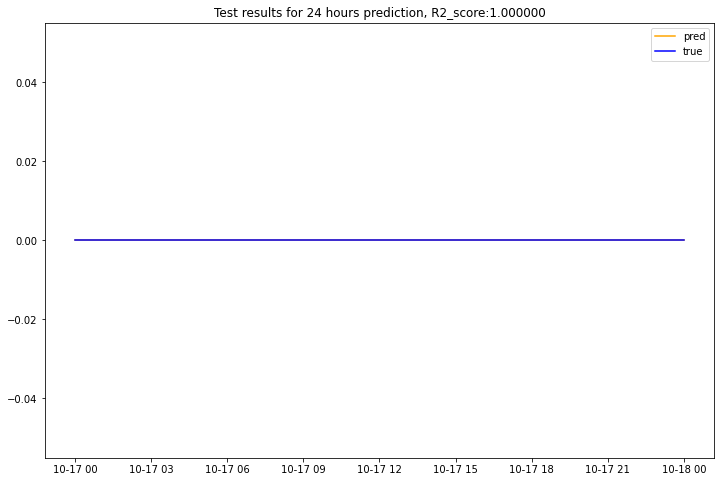

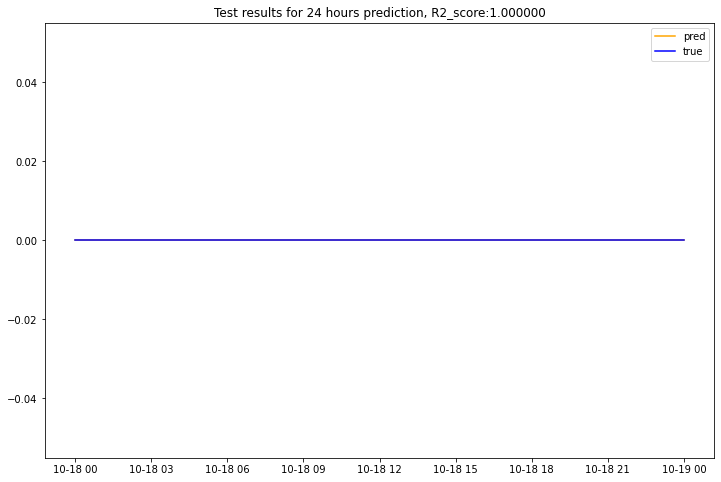

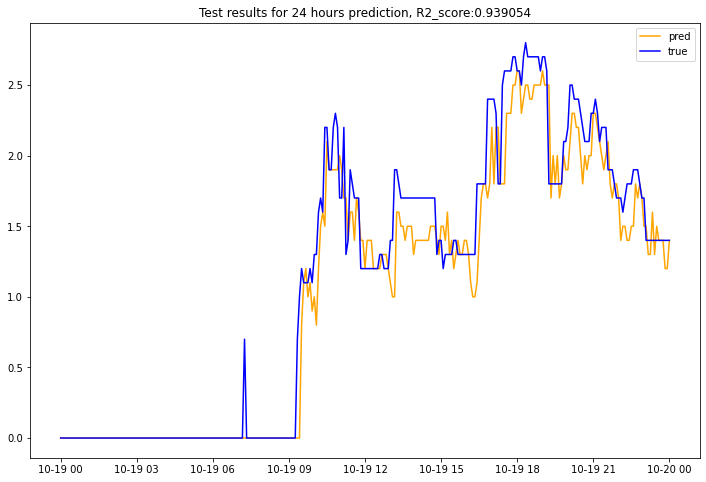

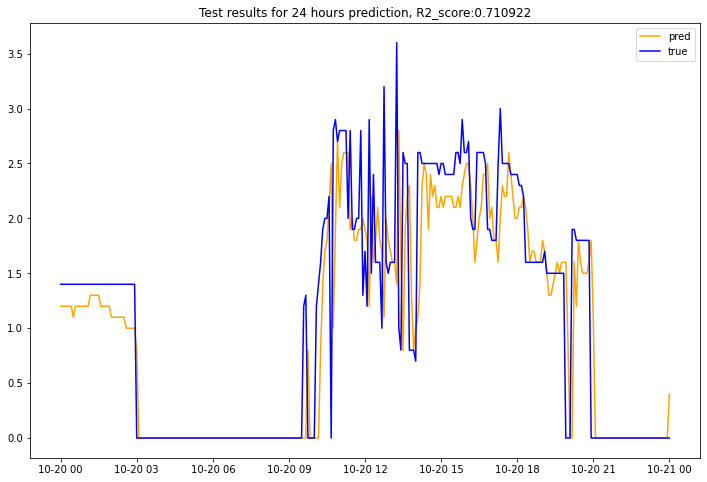

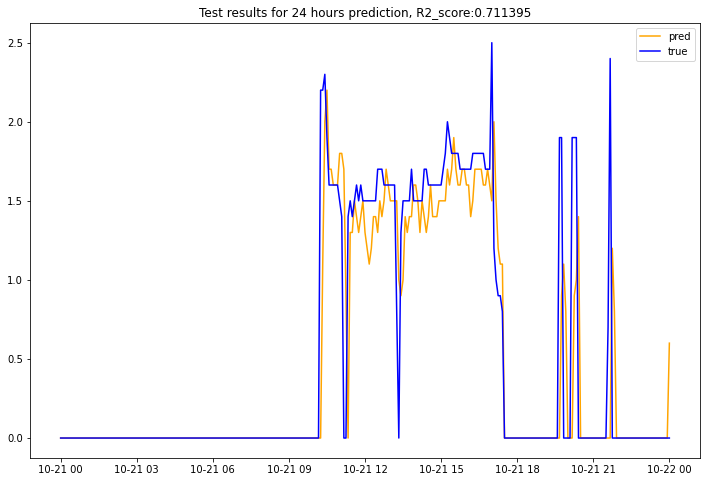

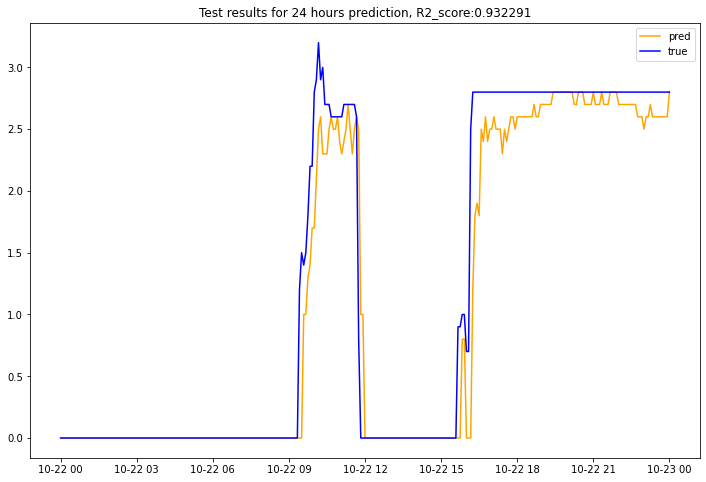

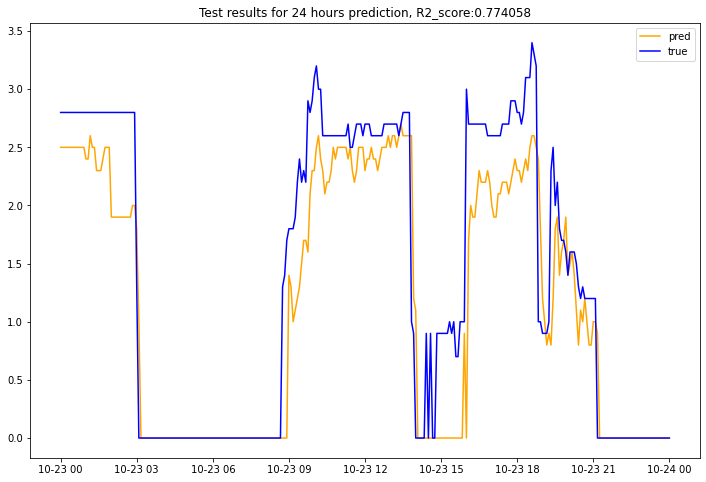

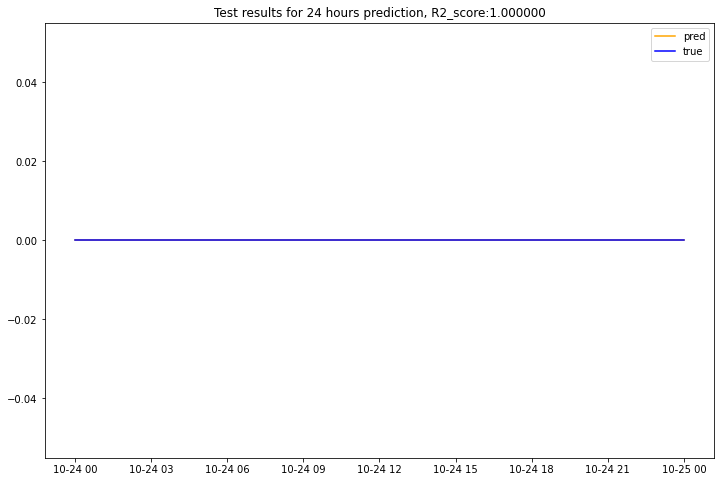

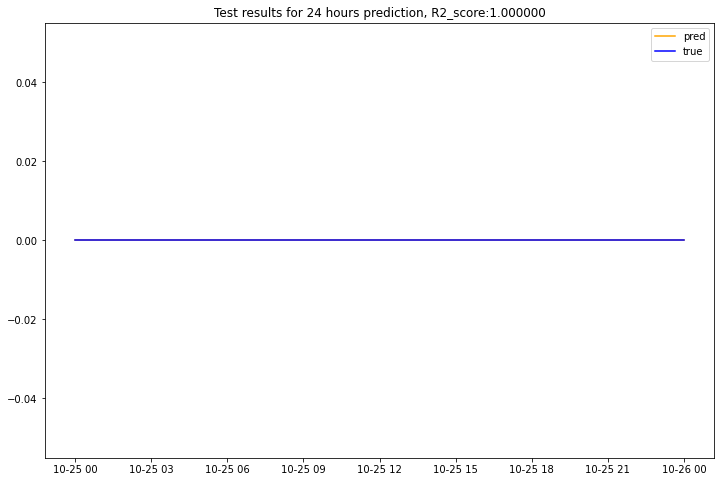

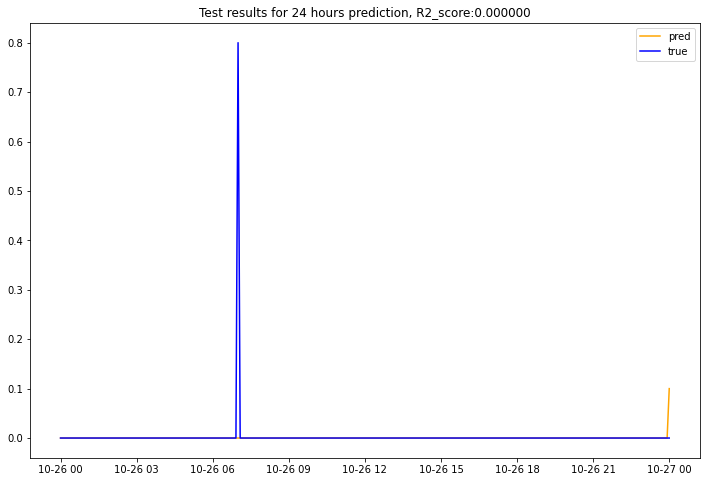

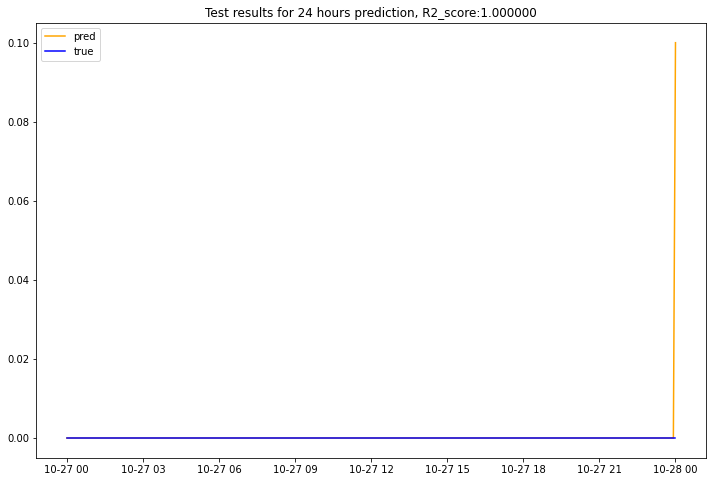

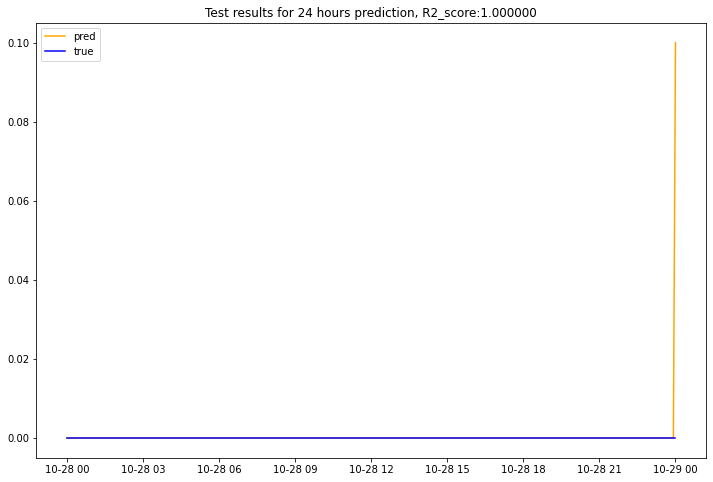

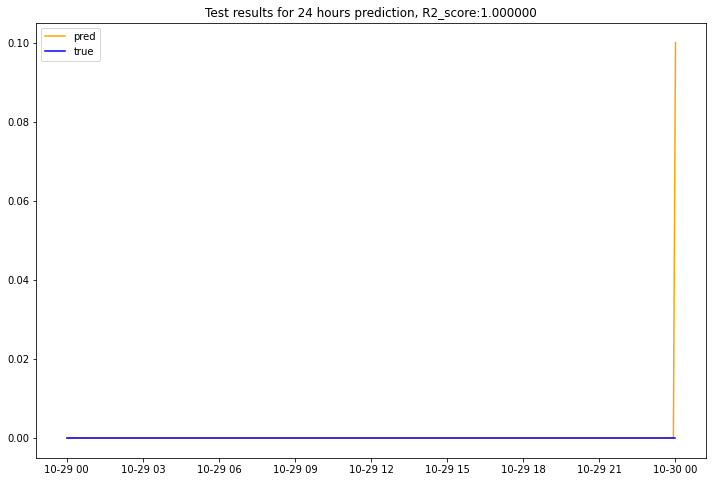

In [209]:
sales_by_date_copy = sales_by_date.copy()
r2=[]

sales_by_date_copy['label_true'] = sales_by_date_copy['label']
for k  in range(0,len(sales_by_date_copy['label_true'])):
  if sales_by_date_copy['label_true'][k]<0.7:
    sales_by_date_copy['label_true'][k] = 0
#sales_by_date_copy['label_true'] = sales_by_date_copy['label_true'].clip(lower=0.4)
sales_by_date_copy.reset_index(inplace=True)
month_pred= []
for j in range (1,30):
  start_date = datetime(2015,10,j)
  end_date = datetime(2015,10,j+1,0)
  num_dates = 12*24
# loop over days and generate score for each day
  for i in range(num_dates):

      date = start_date + 5*timedelta(minutes=i)
      #print(date)
      # compute the features on-the-fly b/c some features depend on predictions
      X_features = sales_by_date_copy
      X_pred = X_features[X_features['time'] == date][feature_cols]
      #print(X_pred)
      # generate predictions
      y_pred = reg_model.predict(X_pred) * magic_factor
      y_pred[y_pred <= zero_threshold] = 0
      month_pred.append(y_pred)
      # update predictions to the sales_by_date dataframe
      sales_by_date_copy.loc[sales_by_date_copy['time'] == date, 'label'] = y_pred

      ## Filter out the final table with our predictions

  sales_by_date_copy2 = sales_by_date_copy.set_index('time').loc[start_date:end_date].reset_index()
  #df_plot = sales_by_date_copy[(sales_by_date_copy.item_id == item_id) & (sales_by_date_copy.store_id == store_id)]
  plt.figure(figsize=(12, 8))
  plt.plot(sales_by_date_copy2.time, sales_by_date_copy2.label.round(1), label='pred',color="orange")
  plt.plot(sales_by_date_copy2.time, sales_by_date_copy2.label_true.round(1), label='true',color="blue")
  plt.legend()
  from sklearn.metrics import r2_score
  from sklearn.metrics import mean_squared_error

  plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(sales_by_date_copy2['label'][0:-2],sales_by_date_copy2['label_true'][0:-2]))

  
  r2.append(r2_score(sales_by_date_copy2['label'][0:-2],sales_by_date_copy2['label_true'][0:-2]))
  print(r2_score(sales_by_date_copy2['label'][0:-2],sales_by_date_copy2['label_true'][0:-2]))
  print(mean_squared_error(sales_by_date_copy2['label'],sales_by_date_copy2['label_true']))


In [102]:
np.mean(r2)

0.8760864266395941

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


-1.627722285582192
0.6672368
0.0
0.0018101867
1.0
1.0089966e-05
0.7777018883348852
0.16337584
0.2583988482346503
0.1052147
0.8681175885944219
0.10682504


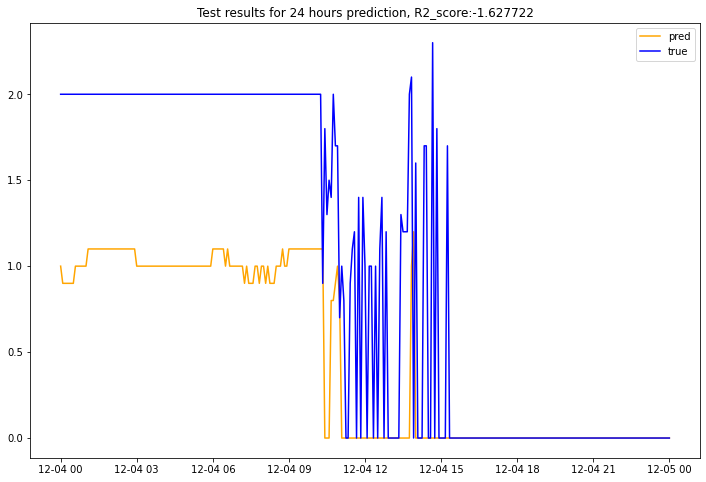

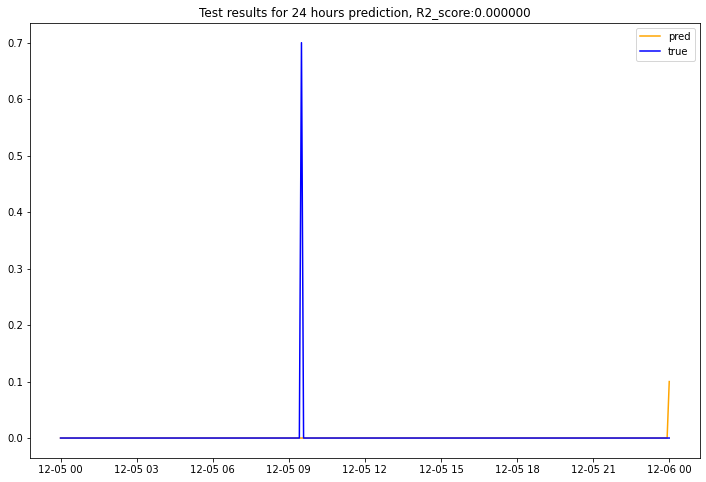

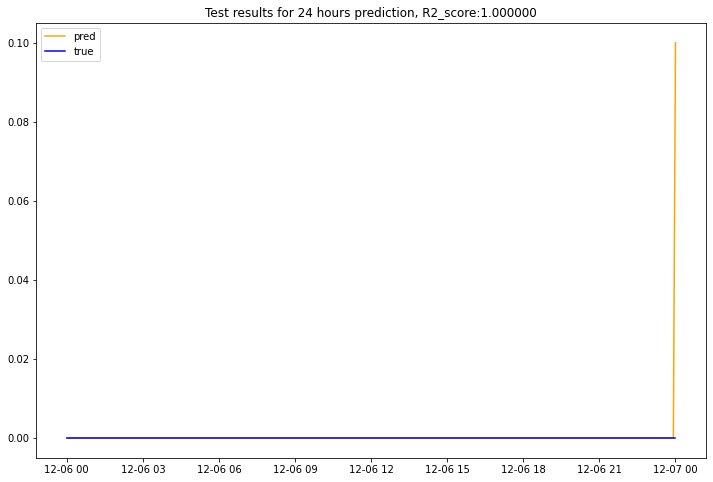

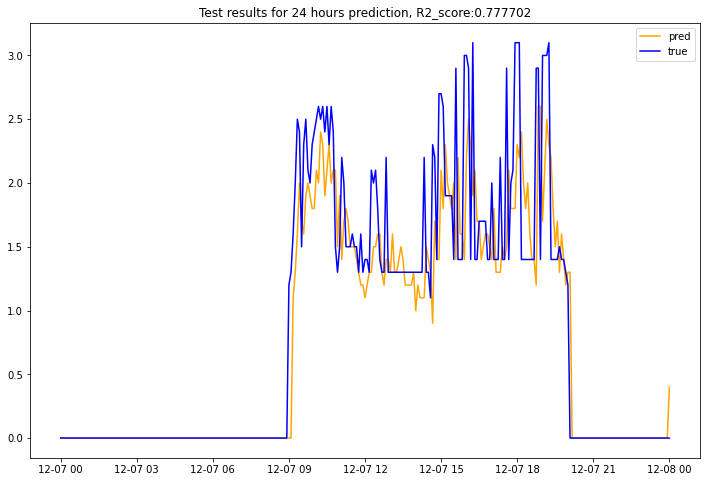

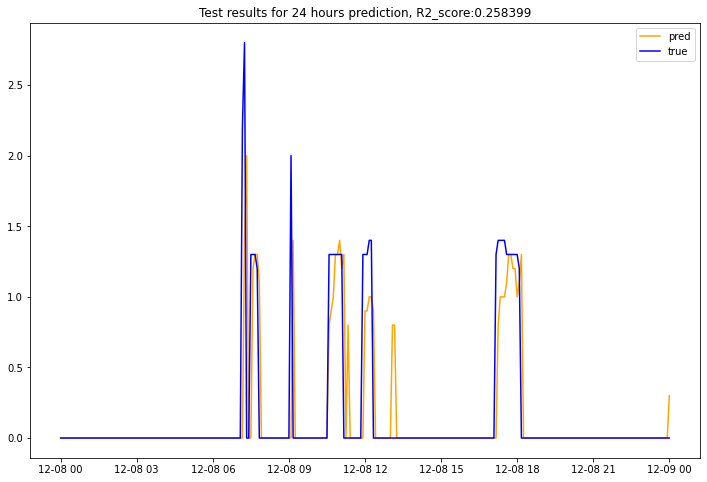

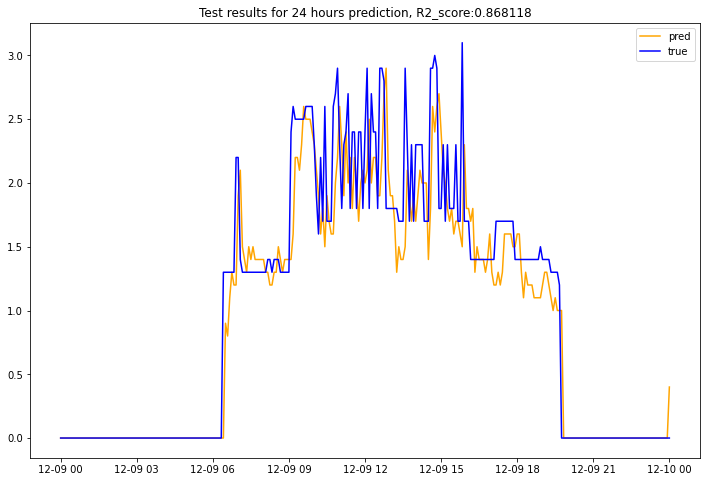

In [210]:
sales_by_date_copy = sales_by_date.copy()


sales_by_date_copy['label_true'] = sales_by_date_copy['label']
for k  in range(0,len(sales_by_date_copy['label_true'])):
  if sales_by_date_copy['label_true'][k]<0.7:
    sales_by_date_copy['label_true'][k] = 0
#sales_by_date_copy['label_true'] = sales_by_date_copy['label_true'].clip(lower=0.4)
sales_by_date_copy.reset_index(inplace=True)
month_pred= []
for j in range (4,10):
  start_date = datetime(2015,12,j)
  end_date = datetime(2015,12,j+1,0)
  num_dates = 12*24
# loop over days and generate score for each day
  for i in range(num_dates):

      date = start_date + 5*timedelta(minutes=i)
      #print(date)
      # compute the features on-the-fly b/c some features depend on predictions
      #X_features = sales_by_date_copy
      X_features = sales_by_date_copy
      X_pred = X_features[X_features['time'] == date][feature_cols]
      #print(X_pred)
      # generate predictions
      y_pred = reg_model.predict(X_pred) * magic_factor
      y_pred[y_pred <= zero_threshold] = 0
      month_pred.append(y_pred)
      # update predictions to the sales_by_date dataframe
      sales_by_date_copy.loc[sales_by_date_copy['time'] == date, 'label'] = y_pred

      ## Filter out the final table with our predictions

  sales_by_date_copy2 = sales_by_date_copy.set_index('time').loc[start_date:end_date].reset_index()
  #df_plot = sales_by_date_copy[(sales_by_date_copy.item_id == item_id) & (sales_by_date_copy.store_id == store_id)]
  plt.figure(figsize=(12, 8))
  plt.plot(sales_by_date_copy2.time, sales_by_date_copy2.label.round(1), label='pred',color="orange")
  plt.plot(sales_by_date_copy2.time, sales_by_date_copy2.label_true.round(1), label='true',color="blue")
  plt.legend()
  from sklearn.metrics import r2_score
  from sklearn.metrics import mean_squared_error

  plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(sales_by_date_copy2['label'][0:-2],sales_by_date_copy2['label_true'][0:-2]))

  
  r2.append(r2_score(sales_by_date_copy2['label'][0:-2],sales_by_date_copy2['label_true'][0:-2]))
  print(r2_score(sales_by_date_copy2['label'][0:-2],sales_by_date_copy2['label_true'][0:-2]))
  print(mean_squared_error(sales_by_date_copy2['label'],sales_by_date_copy2['label_true']))


In [104]:
np.mean(r2)

0.6292869722187097

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


1.0
0.0005155571
0.1913221572045184
0.19042608
0.6286212294312772
0.3742413
0.5788546732285427
0.37963575
0.38365674797904004
0.39776707
0.5871904042423989
0.30899668
0.56585801756466
0.145883
0.6824112980141808
0.12390679
0.5256629506867162
0.25859198
-0.24444240770639758
0.46630955
0.1075975105555751
0.24594338
0.7438133689080657
0.23473649
0.6678618103839398
0.19110945
-0.13747881886344127
0.010063949
1.0
0.00017053288
-0.5722088341746441
0.38942674
0.4855686454057697
0.19887926
0.849901248615108
0.18227178
0.7316510385234833
0.22857136
0.8582509482392542
0.23438297


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.9638927314310797
0.01873874


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.0
0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-0.11194156778480346
0.60945976


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-0.07669231595913129
0.58842325


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-0.09287611930730044
0.44069296


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.1242357673666955
0.48000696


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.368008319003583
0.37646005


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.0
3.4602076e-07


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.0
1.2456748e-07


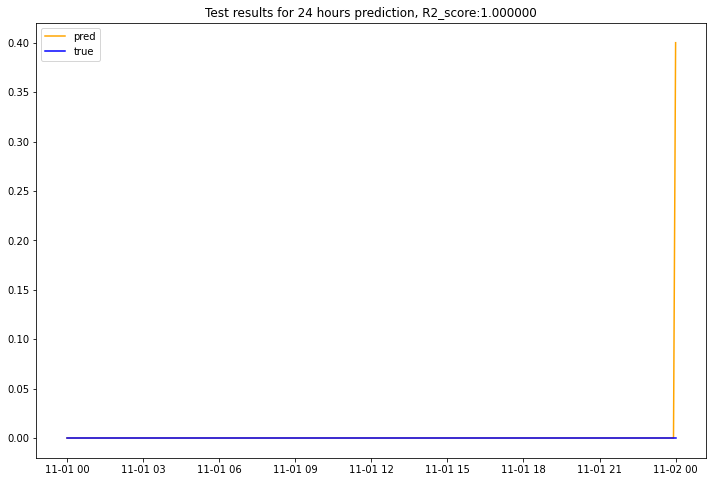

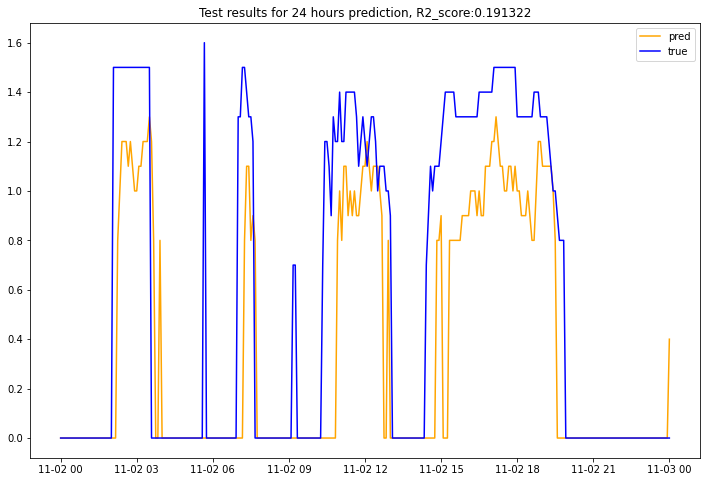

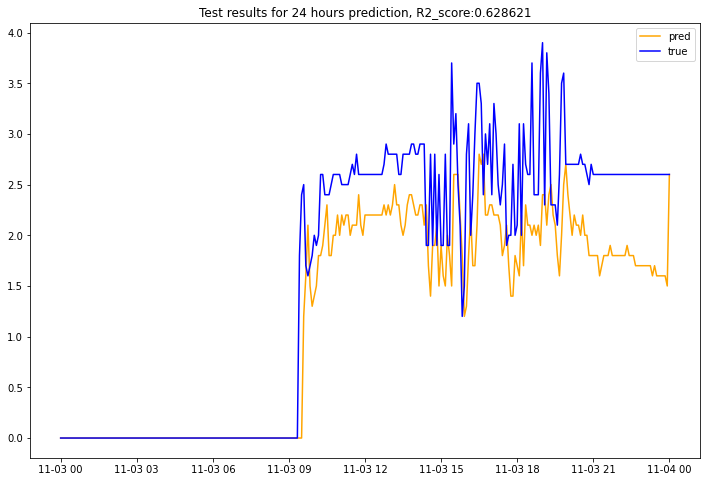

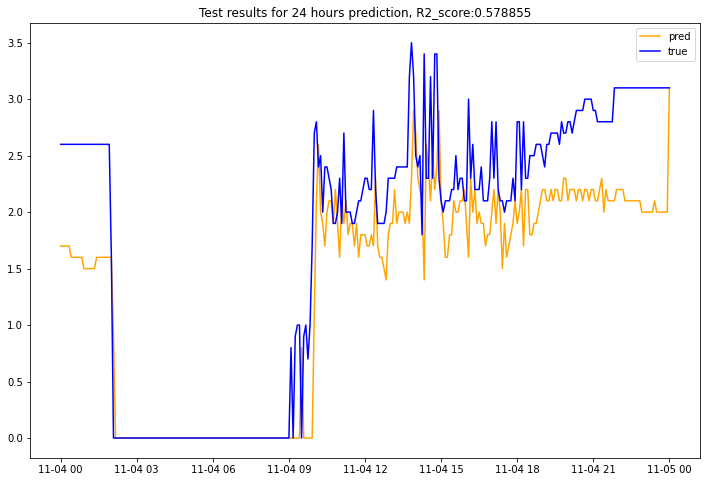

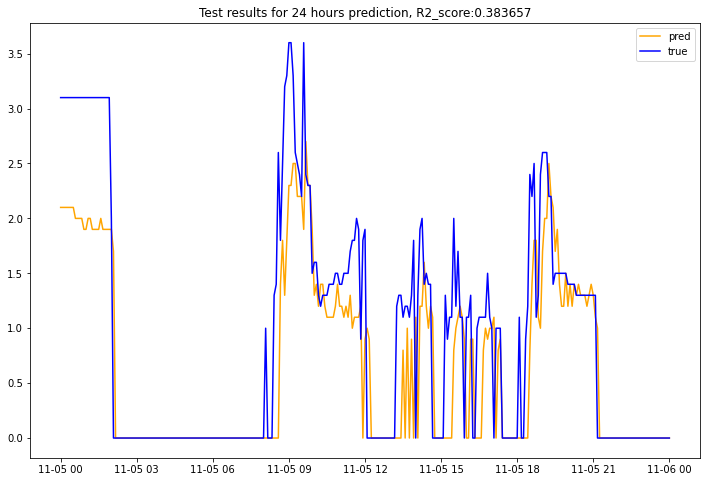

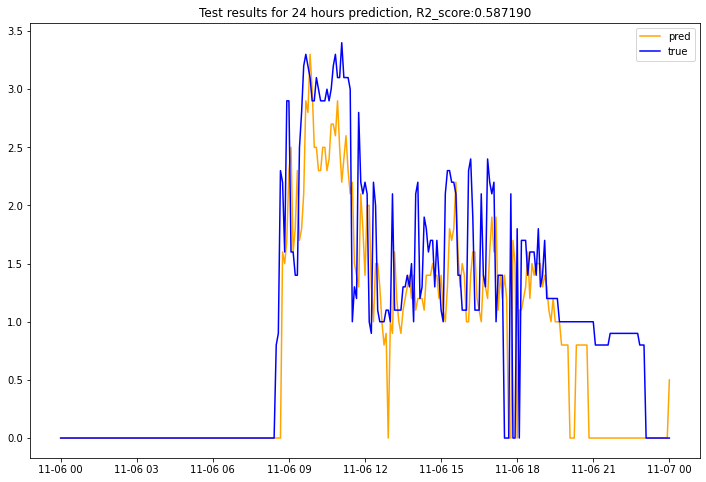

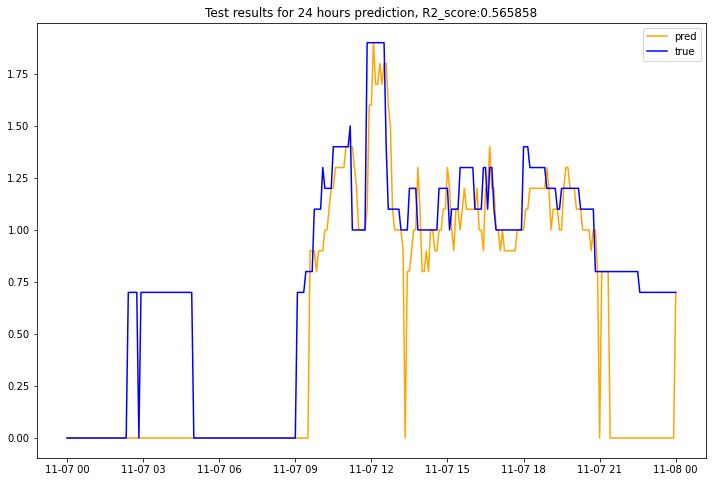

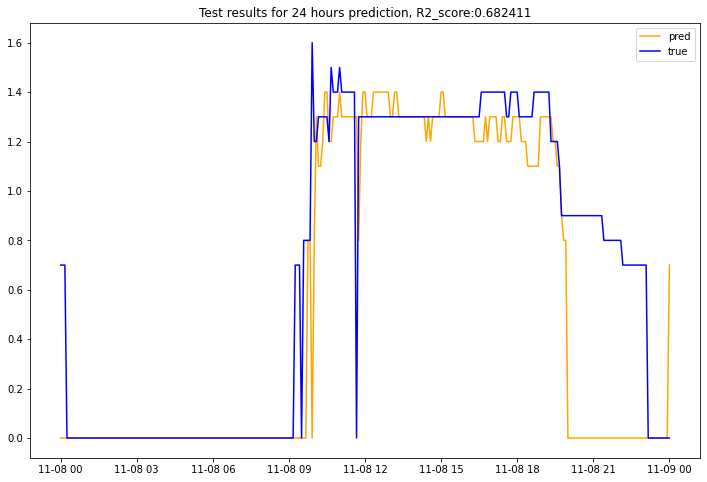

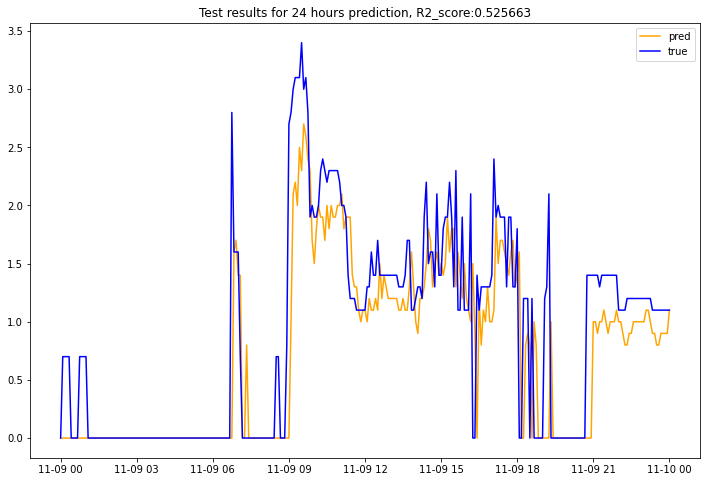

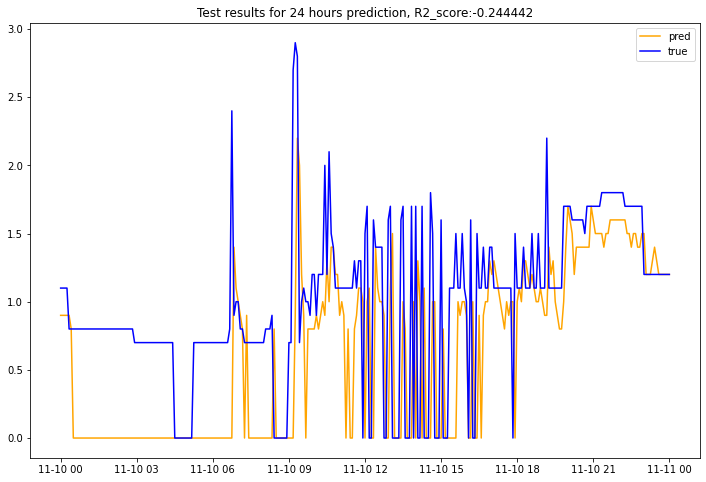

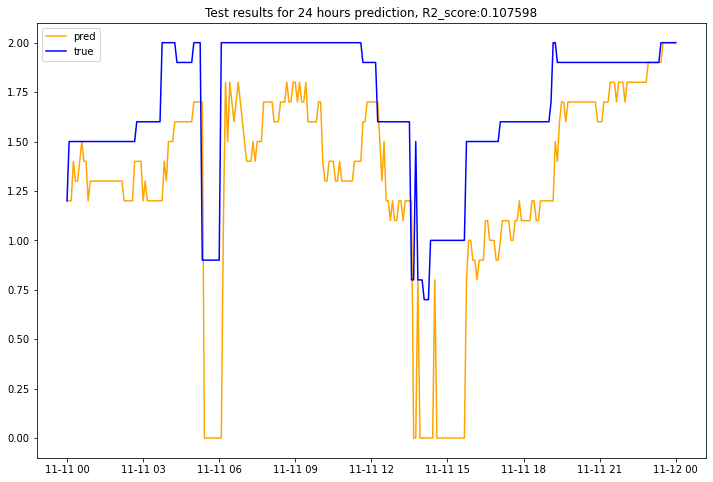

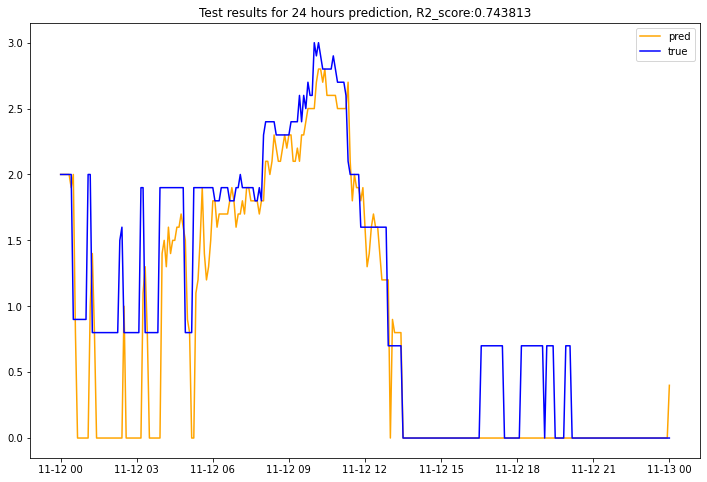

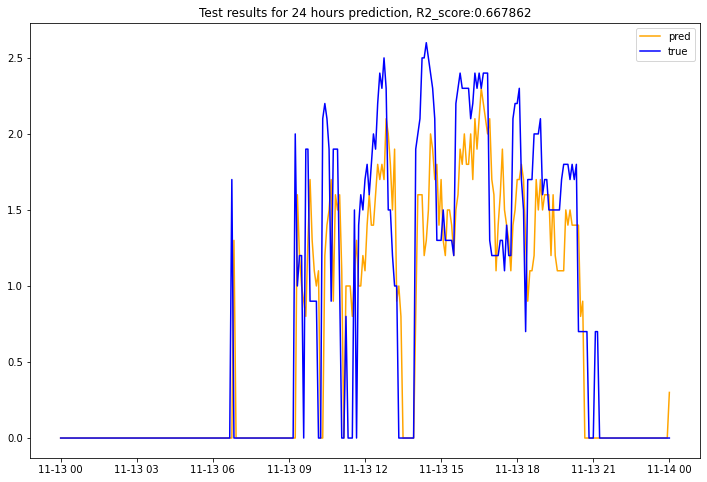

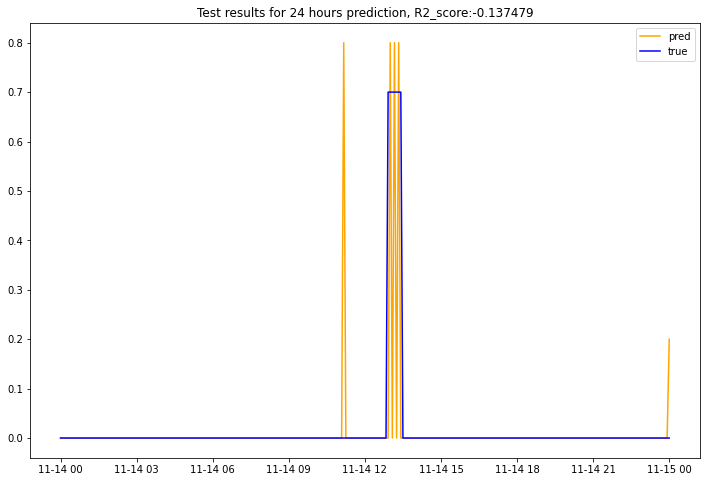

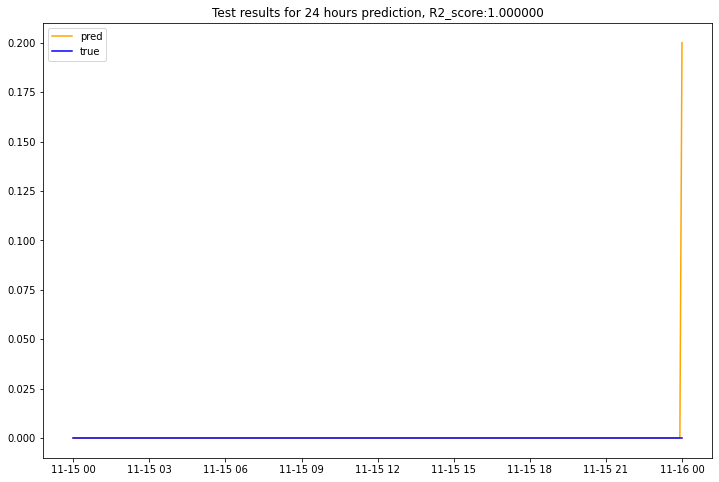

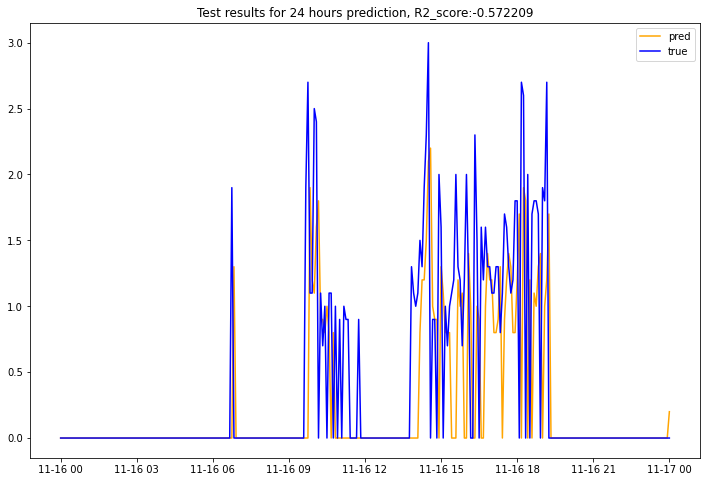

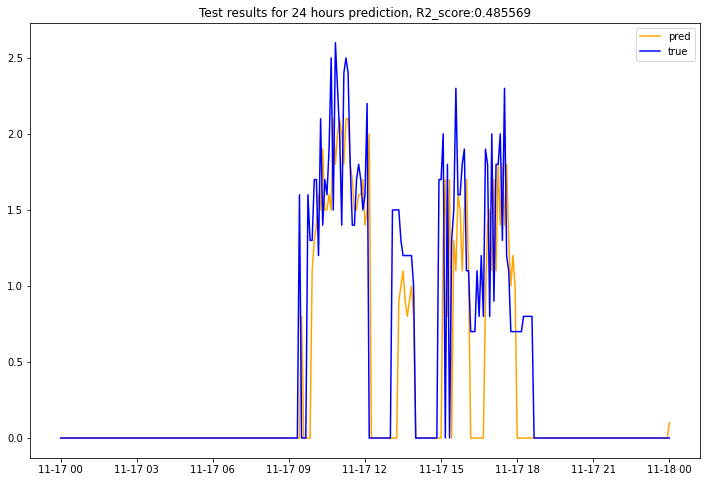

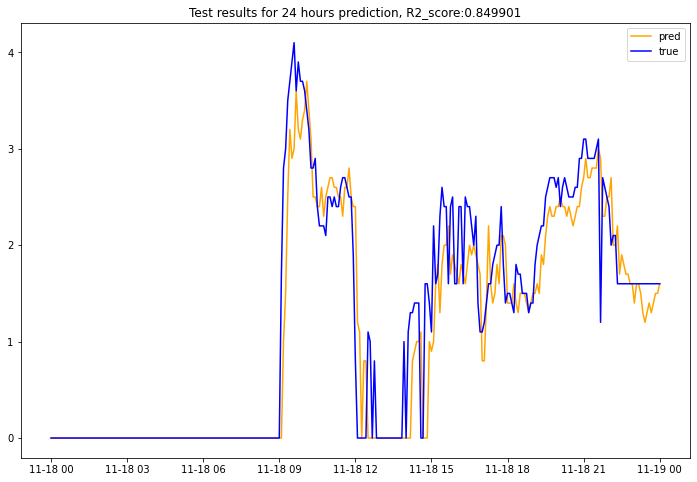

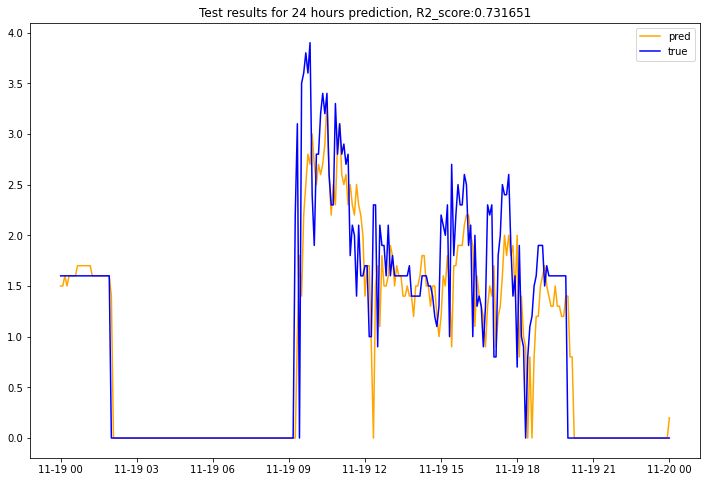

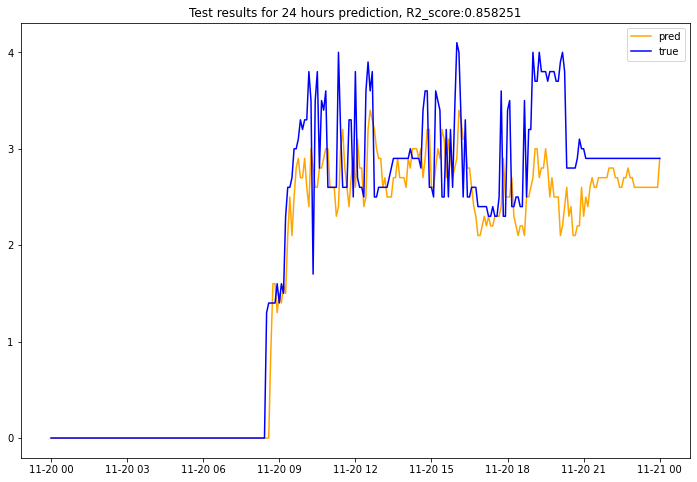

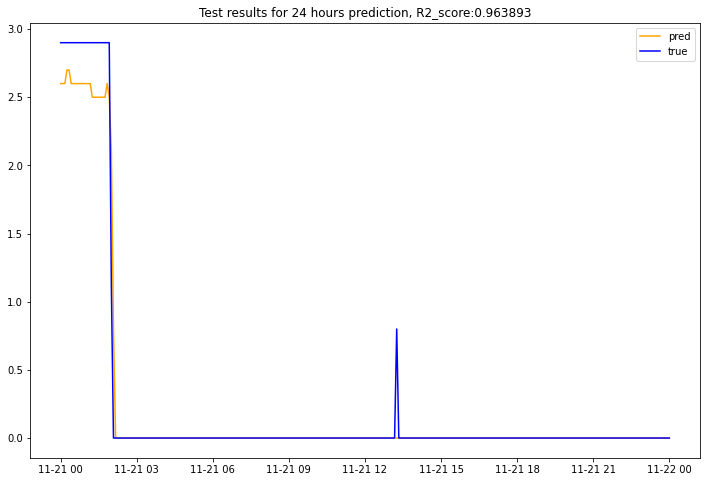

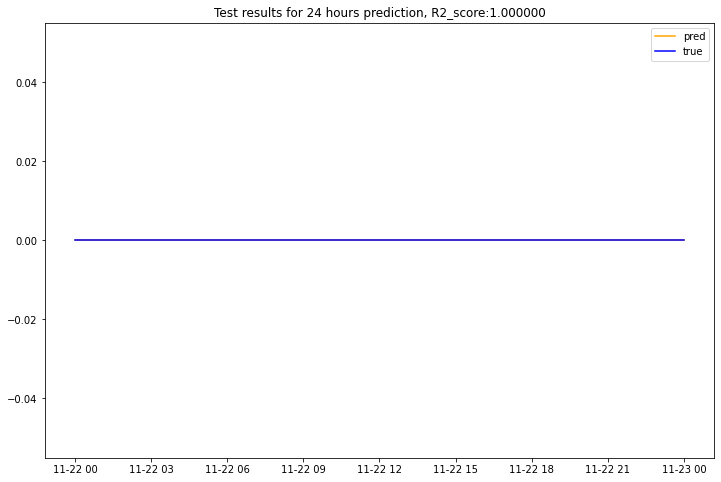

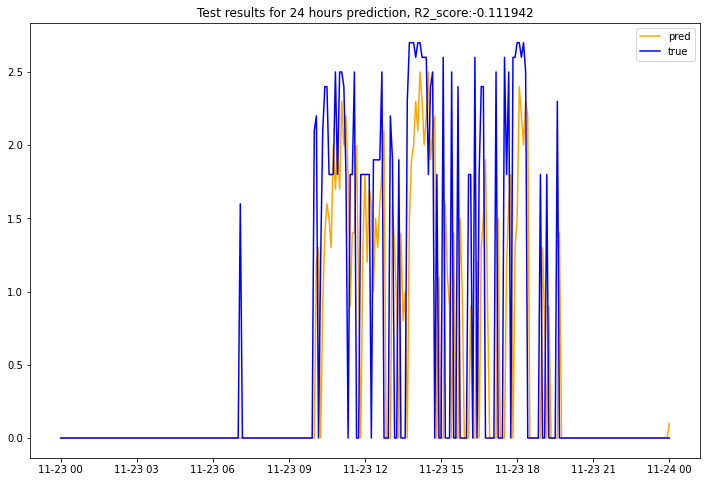

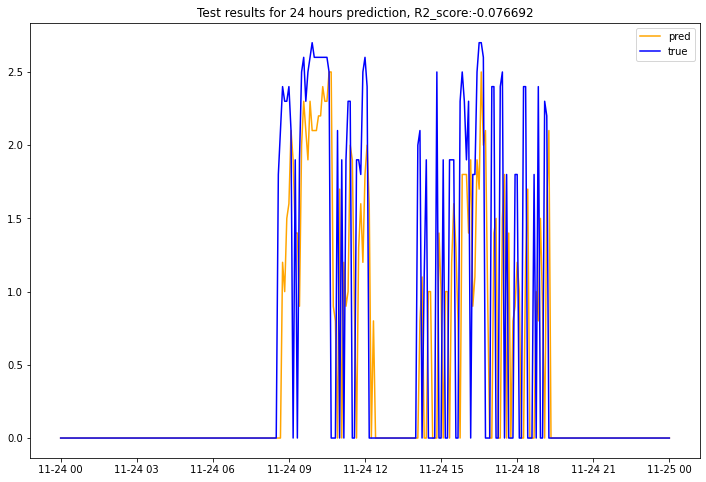

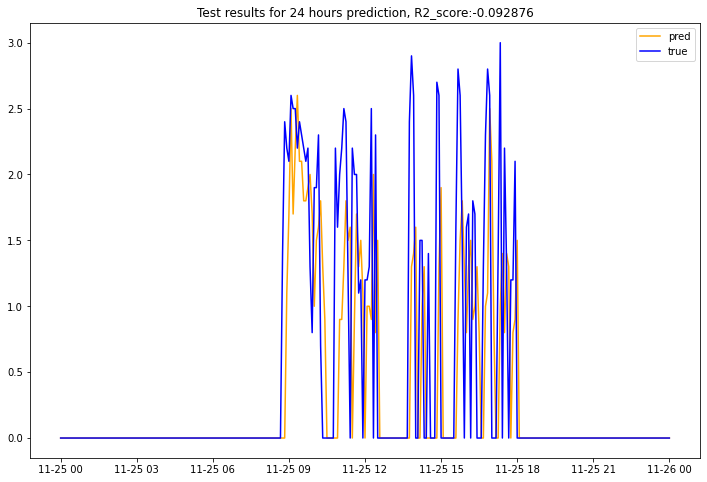

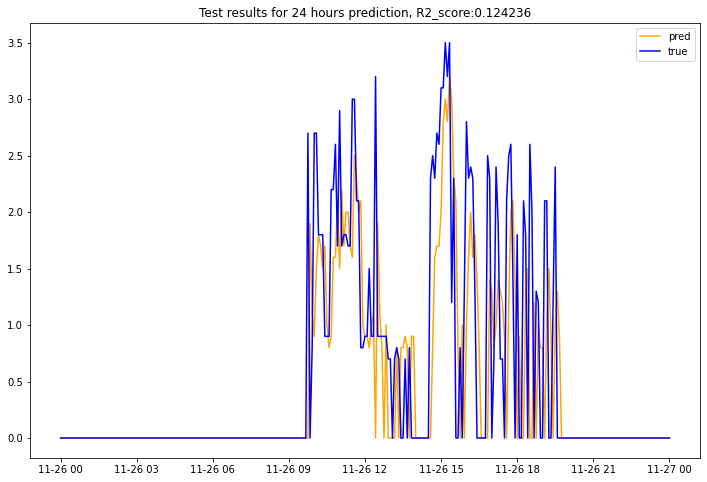

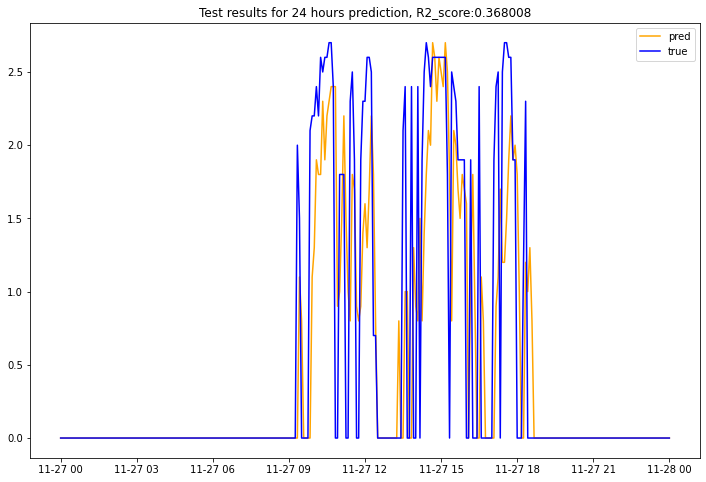

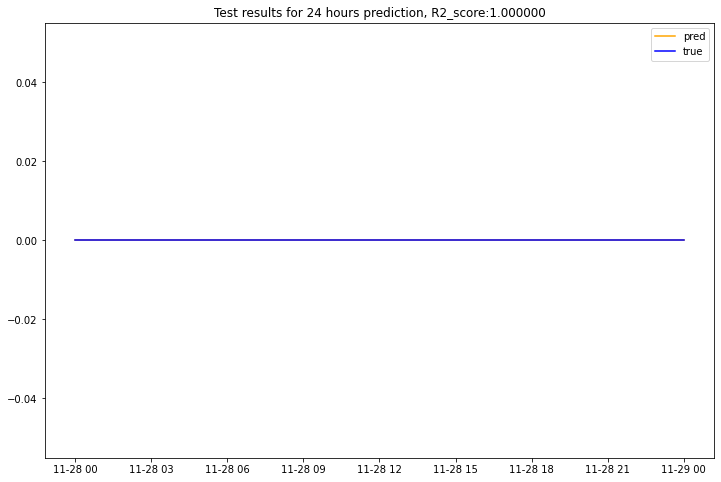

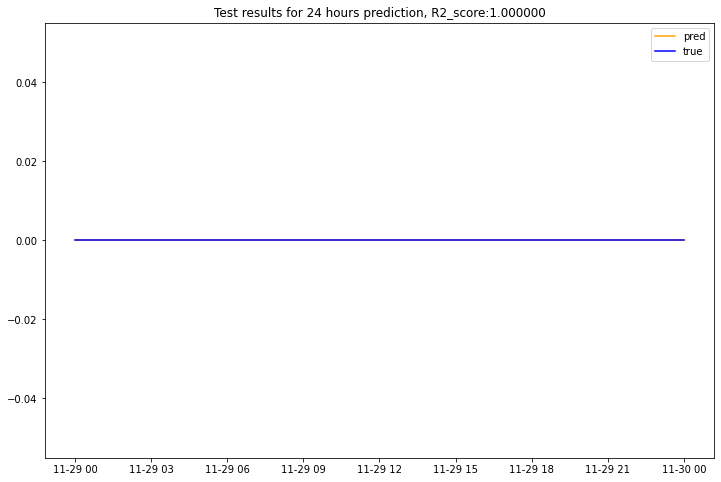

In [105]:
sales_by_date_copy = sales_by_date.copy()


sales_by_date_copy['label_true'] = sales_by_date_copy['label']
for k  in range(0,len(sales_by_date_copy['label_true'])):
  if sales_by_date_copy['label_true'][k]<0.7:
    sales_by_date_copy['label_true'][k] = 0
#sales_by_date_copy['label_true'] = sales_by_date_copy['label_true'].clip(lower=0.4)
sales_by_date_copy.reset_index(inplace=True)
month_pred= []
for j in range (1,30):
  start_date = datetime(2015,11,j)
  end_date = datetime(2015,11,j+1,0)
  num_dates = 12*24
# loop over days and generate score for each day
  for i in range(num_dates):

      date = start_date + 5*timedelta(minutes=i)
      #print(date)
      # compute the features on-the-fly b/c some features depend on predictions
      X_features = sales_by_date_copy
      X_pred = X_features[X_features['time'] == date][feature_cols]
      #print(X_pred)
      # generate predictions
      y_pred = reg_model.predict(X_pred) * magic_factor
      y_pred[y_pred <= zero_threshold] = 0
      month_pred.append(y_pred)
      # update predictions to the sales_by_date dataframe
      sales_by_date_copy.loc[sales_by_date_copy['time'] == date, 'label'] = y_pred

      ## Filter out the final table with our predictions

  sales_by_date_copy2 = sales_by_date_copy.set_index('time').loc[start_date:end_date].reset_index()
  #df_plot = sales_by_date_copy[(sales_by_date_copy.item_id == item_id) & (sales_by_date_copy.store_id == store_id)]
  plt.figure(figsize=(12, 8))
  plt.plot(sales_by_date_copy2.time, sales_by_date_copy2.label.round(1), label='pred',color="orange")
  plt.plot(sales_by_date_copy2.time, sales_by_date_copy2.label_true.round(1), label='true',color="blue")
  plt.legend()
  from sklearn.metrics import r2_score
  from sklearn.metrics import mean_squared_error

  plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(sales_by_date_copy2['label'][0:-2],sales_by_date_copy2['label_true'][0:-2]))

  
  r2.append(r2_score(sales_by_date_copy2['label'][0:-2],sales_by_date_copy2['label_true'][0:-2]))
  print(r2_score(sales_by_date_copy2['label'][0:-2],sales_by_date_copy2['label_true'][0:-2]))
  print(mean_squared_error(sales_by_date_copy2['label'],sales_by_date_copy2['label_true']))


In [106]:
np.mean(r2)

0.5764226461311573